In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                 | 1/2604 [00:01<1:03:46,  1.47s/it]

  0%|                                                                                                                                                   | 2/2604 [00:01<30:35,  1.42it/s]

  0%|▏                                                                                                                                                  | 3/2604 [00:01<19:59,  2.17it/s]

  0%|▏                                                                                                                                                  | 4/2604 [00:01<15:00,  2.89it/s]

  0%|▎                                                                                                                                                  | 5/2604 [00:02<12:15,  3.54it/s]

  0%|▎                                                                                                                                                  | 6/2604 [00:02<10:35,  4.09it/s]

  0%|▍                                                                                                                                                  | 7/2604 [00:02<09:31,  4.54it/s]

  0%|▍                                                                                                                                                  | 8/2604 [00:02<08:50,  4.89it/s]

  0%|▌                                                                                                                                                  | 9/2604 [00:02<08:22,  5.16it/s]

  0%|▌                                                                                                                                                 | 10/2604 [00:03<08:03,  5.37it/s]

  0%|▌                                                                                                                                                 | 11/2604 [00:03<07:50,  5.51it/s]

  0%|▋                                                                                                                                                 | 12/2604 [00:03<07:41,  5.62it/s]

  0%|▋                                                                                                                                                 | 13/2604 [00:03<07:34,  5.70it/s]

  1%|▊                                                                                                                                                 | 14/2604 [00:03<07:30,  5.75it/s]

  1%|▊                                                                                                                                                 | 15/2604 [00:03<07:27,  5.79it/s]

  1%|▉                                                                                                                                                 | 16/2604 [00:04<07:25,  5.81it/s]

  1%|▉                                                                                                                                                 | 17/2604 [00:04<07:23,  5.83it/s]

  1%|█                                                                                                                                                 | 18/2604 [00:04<07:22,  5.85it/s]

  1%|█                                                                                                                                                 | 19/2604 [00:04<07:21,  5.86it/s]

  1%|█                                                                                                                                                 | 20/2604 [00:04<07:20,  5.86it/s]

  1%|█▏                                                                                                                                                | 21/2604 [00:04<07:20,  5.87it/s]

  1%|█▏                                                                                                                                                | 22/2604 [00:05<07:19,  5.87it/s]

  1%|█▎                                                                                                                                                | 23/2604 [00:05<07:20,  5.86it/s]

  1%|█▎                                                                                                                                                | 24/2604 [00:05<07:19,  5.87it/s]

  1%|█▍                                                                                                                                                | 25/2604 [00:05<07:19,  5.87it/s]

  1%|█▍                                                                                                                                                | 26/2604 [00:05<07:18,  5.87it/s]

  1%|█▌                                                                                                                                                | 27/2604 [00:05<07:18,  5.88it/s]

  1%|█▌                                                                                                                                                | 28/2604 [00:06<07:18,  5.88it/s]

  1%|█▋                                                                                                                                                | 29/2604 [00:06<07:18,  5.87it/s]

  1%|█▋                                                                                                                                                | 30/2604 [00:06<07:18,  5.87it/s]

  1%|█▋                                                                                                                                                | 31/2604 [00:06<07:18,  5.87it/s]

  1%|█▊                                                                                                                                                | 32/2604 [00:06<07:18,  5.87it/s]

  1%|█▊                                                                                                                                                | 33/2604 [00:06<07:17,  5.87it/s]

  1%|█▉                                                                                                                                                | 34/2604 [00:07<07:17,  5.87it/s]

  1%|█▉                                                                                                                                                | 35/2604 [00:07<07:17,  5.87it/s]

  1%|██                                                                                                                                                | 36/2604 [00:07<07:16,  5.88it/s]

  1%|██                                                                                                                                                | 37/2604 [00:07<07:16,  5.88it/s]

  1%|██▏                                                                                                                                               | 38/2604 [00:07<07:15,  5.89it/s]

  1%|██▏                                                                                                                                               | 39/2604 [00:07<07:14,  5.90it/s]

  2%|██▏                                                                                                                                               | 40/2604 [00:08<07:13,  5.91it/s]

  2%|██▎                                                                                                                                               | 41/2604 [00:08<07:13,  5.91it/s]

  2%|██▎                                                                                                                                               | 42/2604 [00:08<07:13,  5.91it/s]

  2%|██▍                                                                                                                                               | 43/2604 [00:08<07:12,  5.92it/s]

  2%|██▍                                                                                                                                               | 44/2604 [00:08<07:13,  5.91it/s]

  2%|██▌                                                                                                                                               | 45/2604 [00:08<07:13,  5.90it/s]

  2%|██▌                                                                                                                                               | 46/2604 [00:09<07:14,  5.89it/s]

  2%|██▋                                                                                                                                               | 47/2604 [00:09<07:14,  5.89it/s]

  2%|██▋                                                                                                                                               | 48/2604 [00:09<07:14,  5.89it/s]

  2%|██▋                                                                                                                                               | 49/2604 [00:09<07:14,  5.88it/s]

  2%|██▊                                                                                                                                               | 50/2604 [00:09<07:14,  5.88it/s]

  2%|██▊                                                                                                                                               | 51/2604 [00:09<07:14,  5.87it/s]

  2%|██▉                                                                                                                                               | 52/2604 [00:10<07:14,  5.87it/s]

  2%|██▉                                                                                                                                               | 53/2604 [00:10<07:14,  5.87it/s]

  2%|███                                                                                                                                               | 54/2604 [00:10<07:14,  5.87it/s]

  2%|███                                                                                                                                               | 55/2604 [00:10<07:13,  5.88it/s]

  2%|███▏                                                                                                                                              | 56/2604 [00:10<07:13,  5.88it/s]

  2%|███▏                                                                                                                                              | 57/2604 [00:10<07:13,  5.88it/s]

  2%|███▎                                                                                                                                              | 58/2604 [00:11<07:13,  5.87it/s]

  2%|███▎                                                                                                                                              | 59/2604 [00:11<07:13,  5.87it/s]

  2%|███▎                                                                                                                                              | 60/2604 [00:11<07:13,  5.87it/s]

  2%|███▍                                                                                                                                              | 61/2604 [00:11<07:12,  5.87it/s]

  2%|███▍                                                                                                                                              | 62/2604 [00:11<07:12,  5.88it/s]

  2%|███▌                                                                                                                                              | 63/2604 [00:12<07:12,  5.88it/s]

  2%|███▌                                                                                                                                              | 64/2604 [00:12<07:12,  5.88it/s]

  2%|███▋                                                                                                                                              | 65/2604 [00:12<07:12,  5.87it/s]

  3%|███▋                                                                                                                                              | 66/2604 [00:12<07:12,  5.87it/s]

  3%|███▊                                                                                                                                              | 67/2604 [00:12<07:11,  5.88it/s]

  3%|███▊                                                                                                                                              | 68/2604 [00:12<07:11,  5.88it/s]

  3%|███▊                                                                                                                                              | 69/2604 [00:13<07:11,  5.88it/s]

  3%|███▉                                                                                                                                              | 70/2604 [00:13<07:10,  5.88it/s]

  3%|███▉                                                                                                                                              | 71/2604 [00:13<07:10,  5.88it/s]

  3%|████                                                                                                                                              | 72/2604 [00:13<07:11,  5.87it/s]

  3%|████                                                                                                                                              | 73/2604 [00:13<07:10,  5.87it/s]

  3%|████▏                                                                                                                                             | 74/2604 [00:13<07:10,  5.88it/s]

  3%|████▏                                                                                                                                             | 75/2604 [00:14<07:10,  5.88it/s]

  3%|████▎                                                                                                                                             | 76/2604 [00:14<07:10,  5.88it/s]

  3%|████▎                                                                                                                                             | 77/2604 [00:14<07:09,  5.88it/s]

  3%|████▎                                                                                                                                             | 78/2604 [00:14<07:09,  5.88it/s]

  3%|████▍                                                                                                                                             | 79/2604 [00:14<07:09,  5.87it/s]

  3%|████▍                                                                                                                                             | 80/2604 [00:14<07:09,  5.88it/s]

  3%|████▌                                                                                                                                             | 81/2604 [00:15<07:09,  5.88it/s]

  3%|████▌                                                                                                                                             | 82/2604 [00:15<07:08,  5.88it/s]

  3%|████▋                                                                                                                                             | 83/2604 [00:15<07:08,  5.88it/s]

  3%|████▋                                                                                                                                             | 84/2604 [00:15<07:08,  5.88it/s]

  3%|████▊                                                                                                                                             | 85/2604 [00:15<07:08,  5.88it/s]

  3%|████▊                                                                                                                                             | 86/2604 [00:15<07:08,  5.87it/s]

  3%|████▉                                                                                                                                             | 87/2604 [00:16<07:08,  5.87it/s]

  3%|████▉                                                                                                                                             | 88/2604 [00:16<07:08,  5.88it/s]

  3%|████▉                                                                                                                                             | 89/2604 [00:16<07:08,  5.88it/s]

  3%|█████                                                                                                                                             | 90/2604 [00:16<07:07,  5.88it/s]

  3%|█████                                                                                                                                             | 91/2604 [00:16<07:07,  5.88it/s]

  4%|█████▏                                                                                                                                            | 92/2604 [00:16<07:07,  5.88it/s]

  4%|█████▏                                                                                                                                            | 93/2604 [00:17<07:07,  5.88it/s]

  4%|█████▎                                                                                                                                            | 94/2604 [00:17<07:06,  5.89it/s]

  4%|█████▎                                                                                                                                            | 95/2604 [00:17<07:05,  5.90it/s]

  4%|█████▍                                                                                                                                            | 96/2604 [00:17<07:04,  5.90it/s]

  4%|█████▍                                                                                                                                            | 97/2604 [00:17<07:04,  5.91it/s]

  4%|█████▍                                                                                                                                            | 98/2604 [00:17<07:03,  5.91it/s]

  4%|█████▌                                                                                                                                            | 99/2604 [00:18<07:03,  5.92it/s]

  4%|█████▌                                                                                                                                           | 100/2604 [00:18<07:03,  5.91it/s]

  4%|█████▌                                                                                                                                           | 101/2604 [00:18<07:04,  5.90it/s]

  4%|█████▋                                                                                                                                           | 102/2604 [00:18<07:04,  5.89it/s]

  4%|█████▋                                                                                                                                           | 103/2604 [00:18<07:04,  5.89it/s]

  4%|█████▊                                                                                                                                           | 104/2604 [00:18<07:04,  5.89it/s]

  4%|█████▊                                                                                                                                           | 105/2604 [00:19<07:04,  5.88it/s]

  4%|█████▉                                                                                                                                           | 106/2604 [00:19<07:04,  5.88it/s]

  4%|█████▉                                                                                                                                           | 107/2604 [00:19<07:05,  5.87it/s]

  4%|██████                                                                                                                                           | 108/2604 [00:19<07:05,  5.87it/s]

  4%|██████                                                                                                                                           | 109/2604 [00:19<07:04,  5.87it/s]

  4%|██████▏                                                                                                                                          | 110/2604 [00:20<07:04,  5.87it/s]

  4%|██████▏                                                                                                                                          | 111/2604 [00:20<07:04,  5.87it/s]

  4%|██████▏                                                                                                                                          | 112/2604 [00:20<07:04,  5.87it/s]

  4%|██████▎                                                                                                                                          | 113/2604 [00:20<07:04,  5.87it/s]

  4%|██████▎                                                                                                                                          | 114/2604 [00:20<07:04,  5.87it/s]

  4%|██████▍                                                                                                                                          | 115/2604 [00:20<07:04,  5.87it/s]

  4%|██████▍                                                                                                                                          | 116/2604 [00:21<07:03,  5.87it/s]

  4%|██████▌                                                                                                                                          | 117/2604 [00:21<07:03,  5.87it/s]

  5%|██████▌                                                                                                                                          | 118/2604 [00:21<07:03,  5.88it/s]

  5%|██████▋                                                                                                                                          | 119/2604 [00:21<07:02,  5.88it/s]

  5%|██████▋                                                                                                                                          | 120/2604 [00:21<07:02,  5.87it/s]

  5%|██████▋                                                                                                                                          | 121/2604 [00:21<07:03,  5.87it/s]

  5%|██████▊                                                                                                                                          | 122/2604 [00:22<07:02,  5.87it/s]

  5%|██████▊                                                                                                                                          | 123/2604 [00:22<07:02,  5.87it/s]

  5%|██████▉                                                                                                                                          | 124/2604 [00:22<07:02,  5.88it/s]

  5%|██████▉                                                                                                                                          | 125/2604 [00:22<07:01,  5.88it/s]

  5%|███████                                                                                                                                          | 126/2604 [00:22<07:01,  5.88it/s]

  5%|███████                                                                                                                                          | 127/2604 [00:22<07:01,  5.88it/s]

  5%|███████▏                                                                                                                                         | 128/2604 [00:23<07:01,  5.88it/s]

  5%|███████▏                                                                                                                                         | 129/2604 [00:23<07:01,  5.88it/s]

  5%|███████▏                                                                                                                                         | 130/2604 [00:23<07:00,  5.88it/s]

  5%|███████▎                                                                                                                                         | 131/2604 [00:23<07:00,  5.88it/s]

  5%|███████▎                                                                                                                                         | 132/2604 [00:23<07:00,  5.88it/s]

  5%|███████▍                                                                                                                                         | 133/2604 [00:23<07:00,  5.88it/s]

  5%|███████▍                                                                                                                                         | 134/2604 [00:24<07:00,  5.88it/s]

  5%|███████▌                                                                                                                                         | 135/2604 [00:24<07:00,  5.87it/s]

  5%|███████▌                                                                                                                                         | 136/2604 [00:24<06:59,  5.88it/s]

  5%|███████▋                                                                                                                                         | 137/2604 [00:24<06:59,  5.88it/s]

  5%|███████▋                                                                                                                                         | 138/2604 [00:24<06:59,  5.88it/s]

  5%|███████▋                                                                                                                                         | 139/2604 [00:24<06:59,  5.88it/s]

  5%|███████▊                                                                                                                                         | 140/2604 [00:25<06:59,  5.88it/s]

  5%|███████▊                                                                                                                                         | 141/2604 [00:25<06:58,  5.88it/s]

  5%|███████▉                                                                                                                                         | 142/2604 [00:25<06:59,  5.88it/s]

  5%|███████▉                                                                                                                                         | 143/2604 [00:25<06:58,  5.88it/s]

  6%|████████                                                                                                                                         | 144/2604 [00:25<06:58,  5.88it/s]

  6%|████████                                                                                                                                         | 145/2604 [00:25<06:58,  5.88it/s]

  6%|████████▏                                                                                                                                        | 146/2604 [00:26<06:58,  5.88it/s]

  6%|████████▏                                                                                                                                        | 147/2604 [00:26<06:57,  5.88it/s]

  6%|████████▏                                                                                                                                        | 148/2604 [00:26<06:57,  5.88it/s]

  6%|████████▎                                                                                                                                        | 149/2604 [00:26<06:57,  5.88it/s]

  6%|████████▎                                                                                                                                        | 150/2604 [00:26<06:56,  5.89it/s]

  6%|████████▍                                                                                                                                        | 151/2604 [00:26<06:55,  5.90it/s]

  6%|████████▍                                                                                                                                        | 152/2604 [00:27<06:55,  5.91it/s]

  6%|████████▌                                                                                                                                        | 153/2604 [00:27<06:54,  5.91it/s]

  6%|████████▌                                                                                                                                        | 154/2604 [00:27<06:54,  5.92it/s]

  6%|████████▋                                                                                                                                        | 155/2604 [00:27<06:53,  5.92it/s]

  6%|████████▋                                                                                                                                        | 156/2604 [00:27<06:54,  5.91it/s]

  6%|████████▋                                                                                                                                        | 157/2604 [00:27<06:54,  5.90it/s]

  6%|████████▊                                                                                                                                        | 158/2604 [00:28<06:55,  5.89it/s]

  6%|████████▊                                                                                                                                        | 159/2604 [00:28<06:55,  5.89it/s]

  6%|████████▉                                                                                                                                        | 160/2604 [00:28<06:55,  5.88it/s]

  6%|████████▉                                                                                                                                        | 161/2604 [00:28<06:55,  5.88it/s]

  6%|█████████                                                                                                                                        | 162/2604 [00:28<06:55,  5.88it/s]

  6%|█████████                                                                                                                                        | 163/2604 [00:29<06:55,  5.87it/s]

  6%|█████████▏                                                                                                                                       | 164/2604 [00:29<06:55,  5.87it/s]

  6%|█████████▏                                                                                                                                       | 165/2604 [00:29<06:55,  5.88it/s]

  6%|█████████▏                                                                                                                                       | 166/2604 [00:29<06:54,  5.88it/s]

  6%|█████████▎                                                                                                                                       | 167/2604 [00:29<06:54,  5.88it/s]

  6%|█████████▎                                                                                                                                       | 168/2604 [00:29<06:54,  5.88it/s]

  6%|█████████▍                                                                                                                                       | 169/2604 [00:30<06:54,  5.88it/s]

  7%|█████████▍                                                                                                                                       | 170/2604 [00:30<06:54,  5.87it/s]

  7%|█████████▌                                                                                                                                       | 171/2604 [00:30<06:53,  5.88it/s]

  7%|█████████▌                                                                                                                                       | 172/2604 [00:30<06:53,  5.88it/s]

  7%|█████████▋                                                                                                                                       | 173/2604 [00:30<06:53,  5.88it/s]

  7%|█████████▋                                                                                                                                       | 174/2604 [00:30<06:53,  5.88it/s]

  7%|█████████▋                                                                                                                                       | 175/2604 [00:31<06:53,  5.88it/s]

  7%|█████████▊                                                                                                                                       | 176/2604 [00:31<06:53,  5.87it/s]

  7%|█████████▊                                                                                                                                       | 177/2604 [00:31<06:53,  5.87it/s]

  7%|█████████▉                                                                                                                                       | 178/2604 [00:31<06:53,  5.87it/s]

  7%|█████████▉                                                                                                                                       | 179/2604 [00:31<06:52,  5.87it/s]

  7%|██████████                                                                                                                                       | 180/2604 [00:31<06:52,  5.87it/s]

  7%|██████████                                                                                                                                       | 181/2604 [00:32<06:52,  5.87it/s]

  7%|██████████▏                                                                                                                                      | 182/2604 [00:32<06:52,  5.88it/s]

  7%|██████████▏                                                                                                                                      | 183/2604 [00:32<06:52,  5.88it/s]

  7%|██████████▏                                                                                                                                      | 184/2604 [00:32<06:52,  5.87it/s]

  7%|██████████▎                                                                                                                                      | 185/2604 [00:32<06:52,  5.87it/s]

  7%|██████████▎                                                                                                                                      | 186/2604 [00:32<06:51,  5.87it/s]

  7%|██████████▍                                                                                                                                      | 187/2604 [00:33<06:51,  5.87it/s]

  7%|██████████▍                                                                                                                                      | 188/2604 [00:33<06:51,  5.87it/s]

  7%|██████████▌                                                                                                                                      | 189/2604 [00:33<06:51,  5.87it/s]

  7%|██████████▌                                                                                                                                      | 190/2604 [00:33<06:50,  5.87it/s]

  7%|██████████▋                                                                                                                                      | 191/2604 [00:33<06:51,  5.87it/s]

  7%|██████████▋                                                                                                                                      | 192/2604 [00:33<06:50,  5.87it/s]

  7%|██████████▋                                                                                                                                      | 193/2604 [00:34<06:50,  5.87it/s]

  7%|██████████▊                                                                                                                                      | 194/2604 [00:34<06:50,  5.88it/s]

  7%|██████████▊                                                                                                                                      | 195/2604 [00:34<06:50,  5.88it/s]

  8%|██████████▉                                                                                                                                      | 196/2604 [00:34<06:49,  5.87it/s]

  8%|██████████▉                                                                                                                                      | 197/2604 [00:34<06:49,  5.87it/s]

  8%|███████████                                                                                                                                      | 198/2604 [00:34<06:49,  5.87it/s]

  8%|███████████                                                                                                                                      | 199/2604 [00:35<06:49,  5.87it/s]

  8%|███████████▏                                                                                                                                     | 200/2604 [00:35<06:49,  5.87it/s]

  8%|███████████▏                                                                                                                                     | 201/2604 [00:35<06:49,  5.87it/s]

  8%|███████████▏                                                                                                                                     | 202/2604 [00:35<06:48,  5.87it/s]

  8%|███████████▎                                                                                                                                     | 203/2604 [00:35<06:48,  5.87it/s]

  8%|███████████▎                                                                                                                                     | 204/2604 [00:35<06:48,  5.87it/s]

  8%|███████████▍                                                                                                                                     | 205/2604 [00:36<06:48,  5.87it/s]

  8%|███████████▍                                                                                                                                     | 206/2604 [00:36<06:48,  5.87it/s]

  8%|███████████▌                                                                                                                                     | 207/2604 [00:36<06:48,  5.87it/s]

  8%|███████████▌                                                                                                                                     | 208/2604 [00:36<06:48,  5.87it/s]

  8%|███████████▋                                                                                                                                     | 209/2604 [00:36<06:47,  5.87it/s]

  8%|███████████▋                                                                                                                                     | 210/2604 [00:37<06:47,  5.87it/s]

  8%|███████████▋                                                                                                                                     | 211/2604 [00:37<06:47,  5.88it/s]

  8%|███████████▊                                                                                                                                     | 212/2604 [00:37<06:47,  5.87it/s]

  8%|███████████▊                                                                                                                                     | 213/2604 [00:37<06:47,  5.87it/s]

  8%|███████████▉                                                                                                                                     | 214/2604 [00:37<06:47,  5.87it/s]

  8%|███████████▉                                                                                                                                     | 215/2604 [00:37<06:47,  5.87it/s]

  8%|████████████                                                                                                                                     | 216/2604 [00:38<06:47,  5.87it/s]

  8%|████████████                                                                                                                                     | 217/2604 [00:38<06:46,  5.87it/s]

  8%|████████████▏                                                                                                                                    | 218/2604 [00:38<06:46,  5.87it/s]

  8%|████████████▏                                                                                                                                    | 219/2604 [00:38<06:46,  5.86it/s]

  8%|████████████▎                                                                                                                                    | 220/2604 [00:38<06:46,  5.87it/s]

  8%|████████████▎                                                                                                                                    | 221/2604 [00:38<06:46,  5.87it/s]

  9%|████████████▎                                                                                                                                    | 222/2604 [00:39<06:45,  5.87it/s]

  9%|████████████▍                                                                                                                                    | 223/2604 [00:39<06:45,  5.87it/s]

  9%|████████████▍                                                                                                                                    | 224/2604 [00:39<06:45,  5.87it/s]

  9%|████████████▌                                                                                                                                    | 225/2604 [00:39<06:44,  5.87it/s]

  9%|████████████▌                                                                                                                                    | 226/2604 [00:39<06:45,  5.87it/s]

  9%|████████████▋                                                                                                                                    | 227/2604 [00:39<06:44,  5.87it/s]

  9%|████████████▋                                                                                                                                    | 228/2604 [00:40<06:44,  5.87it/s]

  9%|████████████▊                                                                                                                                    | 229/2604 [00:40<06:44,  5.87it/s]

  9%|████████████▊                                                                                                                                    | 230/2604 [00:40<06:44,  5.87it/s]

  9%|████████████▊                                                                                                                                    | 231/2604 [00:40<06:44,  5.87it/s]

  9%|████████████▉                                                                                                                                    | 232/2604 [00:40<06:43,  5.87it/s]

  9%|████████████▉                                                                                                                                    | 233/2604 [00:40<06:44,  5.87it/s]

  9%|█████████████                                                                                                                                    | 234/2604 [00:41<06:43,  5.87it/s]

  9%|█████████████                                                                                                                                    | 235/2604 [00:41<06:43,  5.87it/s]

  9%|█████████████▏                                                                                                                                   | 236/2604 [00:41<06:43,  5.87it/s]

  9%|█████████████▏                                                                                                                                   | 237/2604 [00:41<06:43,  5.87it/s]

  9%|█████████████▎                                                                                                                                   | 238/2604 [00:41<06:42,  5.87it/s]

  9%|█████████████▎                                                                                                                                   | 239/2604 [00:41<06:42,  5.88it/s]

  9%|█████████████▎                                                                                                                                   | 240/2604 [00:42<06:42,  5.87it/s]

  9%|█████████████▍                                                                                                                                   | 241/2604 [00:42<06:42,  5.87it/s]

  9%|█████████████▍                                                                                                                                   | 242/2604 [00:42<06:42,  5.87it/s]

  9%|█████████████▌                                                                                                                                   | 243/2604 [00:42<06:42,  5.87it/s]

  9%|█████████████▌                                                                                                                                   | 244/2604 [00:42<06:41,  5.87it/s]

  9%|█████████████▋                                                                                                                                   | 245/2604 [00:42<06:41,  5.87it/s]

  9%|█████████████▋                                                                                                                                   | 246/2604 [00:43<06:41,  5.87it/s]

  9%|█████████████▊                                                                                                                                   | 247/2604 [00:43<06:41,  5.87it/s]

 10%|█████████████▊                                                                                                                                   | 248/2604 [00:43<06:41,  5.87it/s]

 10%|█████████████▊                                                                                                                                   | 249/2604 [00:43<06:41,  5.87it/s]

 10%|█████████████▉                                                                                                                                   | 250/2604 [00:43<06:41,  5.86it/s]

 10%|█████████████▉                                                                                                                                   | 251/2604 [00:44<06:40,  5.87it/s]

 10%|██████████████                                                                                                                                   | 252/2604 [00:44<06:40,  5.87it/s]

 10%|██████████████                                                                                                                                   | 253/2604 [00:44<06:40,  5.87it/s]

 10%|██████████████▏                                                                                                                                  | 254/2604 [00:44<06:39,  5.88it/s]

 10%|██████████████▏                                                                                                                                  | 255/2604 [00:44<06:39,  5.88it/s]

 10%|██████████████▎                                                                                                                                  | 256/2604 [00:44<06:39,  5.88it/s]

 10%|██████████████▎                                                                                                                                  | 257/2604 [00:45<06:39,  5.88it/s]

 10%|██████████████▎                                                                                                                                  | 258/2604 [00:45<06:39,  5.88it/s]

 10%|██████████████▍                                                                                                                                  | 259/2604 [00:45<06:39,  5.88it/s]

 10%|██████████████▍                                                                                                                                  | 260/2604 [00:45<06:38,  5.88it/s]

 10%|██████████████▌                                                                                                                                  | 261/2604 [00:45<06:38,  5.88it/s]

 10%|██████████████▌                                                                                                                                  | 262/2604 [00:45<06:38,  5.88it/s]

 10%|██████████████▋                                                                                                                                  | 263/2604 [00:46<06:38,  5.88it/s]

 10%|██████████████▋                                                                                                                                  | 264/2604 [00:46<06:38,  5.88it/s]

 10%|██████████████▊                                                                                                                                  | 265/2604 [00:46<06:37,  5.88it/s]

 10%|██████████████▊                                                                                                                                  | 266/2604 [00:46<06:37,  5.88it/s]

 10%|██████████████▊                                                                                                                                  | 267/2604 [00:46<06:37,  5.88it/s]

 10%|██████████████▉                                                                                                                                  | 268/2604 [00:46<06:37,  5.88it/s]

 10%|██████████████▉                                                                                                                                  | 269/2604 [00:47<06:37,  5.88it/s]

 10%|███████████████                                                                                                                                  | 270/2604 [00:47<06:37,  5.88it/s]

 10%|███████████████                                                                                                                                  | 271/2604 [00:47<06:36,  5.88it/s]

 10%|███████████████▏                                                                                                                                 | 272/2604 [00:47<06:36,  5.88it/s]

 10%|███████████████▏                                                                                                                                 | 273/2604 [00:47<06:36,  5.88it/s]

 11%|███████████████▎                                                                                                                                 | 274/2604 [00:47<06:36,  5.88it/s]

 11%|███████████████▎                                                                                                                                 | 275/2604 [00:48<06:36,  5.88it/s]

 11%|███████████████▎                                                                                                                                 | 276/2604 [00:48<06:36,  5.88it/s]

 11%|███████████████▍                                                                                                                                 | 277/2604 [00:48<06:36,  5.87it/s]

 11%|███████████████▍                                                                                                                                 | 278/2604 [00:48<06:36,  5.87it/s]

 11%|███████████████▌                                                                                                                                 | 279/2604 [00:48<06:35,  5.87it/s]

 11%|███████████████▌                                                                                                                                 | 280/2604 [00:48<06:35,  5.87it/s]

 11%|███████████████▋                                                                                                                                 | 281/2604 [00:49<06:35,  5.87it/s]

 11%|███████████████▋                                                                                                                                 | 282/2604 [00:49<06:35,  5.87it/s]

 11%|███████████████▊                                                                                                                                 | 283/2604 [00:49<06:35,  5.87it/s]

 11%|███████████████▊                                                                                                                                 | 284/2604 [00:49<06:35,  5.87it/s]

 11%|███████████████▊                                                                                                                                 | 285/2604 [00:49<06:35,  5.87it/s]

 11%|███████████████▉                                                                                                                                 | 286/2604 [00:49<06:35,  5.86it/s]

 11%|███████████████▉                                                                                                                                 | 287/2604 [00:50<06:34,  5.87it/s]

 11%|████████████████                                                                                                                                 | 288/2604 [00:50<06:34,  5.87it/s]

 11%|████████████████                                                                                                                                 | 289/2604 [00:50<06:34,  5.87it/s]

 11%|████████████████▏                                                                                                                                | 290/2604 [00:50<06:34,  5.87it/s]

 11%|████████████████▏                                                                                                                                | 291/2604 [00:50<06:34,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 292/2604 [00:50<06:33,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 293/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 294/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▍                                                                                                                                | 295/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▍                                                                                                                                | 296/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▌                                                                                                                                | 297/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▌                                                                                                                                | 298/2604 [00:52<06:32,  5.87it/s]

 11%|████████████████▋                                                                                                                                | 299/2604 [00:52<06:32,  5.87it/s]

 12%|████████████████▋                                                                                                                                | 300/2604 [00:52<06:32,  5.87it/s]

 12%|████████████████▊                                                                                                                                | 301/2604 [00:52<06:32,  5.87it/s]

 12%|████████████████▊                                                                                                                                | 302/2604 [00:52<06:31,  5.87it/s]

 12%|████████████████▊                                                                                                                                | 303/2604 [00:52<06:31,  5.87it/s]

 12%|████████████████▉                                                                                                                                | 304/2604 [00:53<06:31,  5.87it/s]

 12%|████████████████▉                                                                                                                                | 305/2604 [00:53<06:31,  5.87it/s]

 12%|█████████████████                                                                                                                                | 306/2604 [00:53<06:31,  5.87it/s]

 12%|█████████████████                                                                                                                                | 307/2604 [00:53<06:30,  5.88it/s]

 12%|█████████████████▏                                                                                                                               | 308/2604 [00:53<06:30,  5.88it/s]

 12%|█████████████████▏                                                                                                                               | 309/2604 [00:53<06:30,  5.87it/s]

 12%|█████████████████▎                                                                                                                               | 310/2604 [00:54<06:30,  5.87it/s]

 12%|█████████████████▎                                                                                                                               | 311/2604 [00:54<06:30,  5.87it/s]

 12%|█████████████████▎                                                                                                                               | 312/2604 [00:54<06:30,  5.87it/s]

 12%|█████████████████▍                                                                                                                               | 313/2604 [00:54<06:30,  5.87it/s]

 12%|█████████████████▍                                                                                                                               | 314/2604 [00:54<06:29,  5.87it/s]

 12%|█████████████████▌                                                                                                                               | 315/2604 [00:54<06:29,  5.88it/s]

 12%|█████████████████▌                                                                                                                               | 316/2604 [00:55<06:29,  5.88it/s]

 12%|█████████████████▋                                                                                                                               | 317/2604 [00:55<06:29,  5.87it/s]

 12%|█████████████████▋                                                                                                                               | 318/2604 [00:55<06:29,  5.87it/s]

 12%|█████████████████▊                                                                                                                               | 319/2604 [00:55<06:29,  5.87it/s]

 12%|█████████████████▊                                                                                                                               | 320/2604 [00:55<06:29,  5.87it/s]

 12%|█████████████████▊                                                                                                                               | 321/2604 [00:55<06:28,  5.87it/s]

 12%|█████████████████▉                                                                                                                               | 322/2604 [00:56<06:28,  5.87it/s]

 12%|█████████████████▉                                                                                                                               | 323/2604 [00:56<06:28,  5.87it/s]

 12%|██████████████████                                                                                                                               | 324/2604 [00:56<06:28,  5.87it/s]

 12%|██████████████████                                                                                                                               | 325/2604 [00:56<06:28,  5.87it/s]

 13%|██████████████████▏                                                                                                                              | 326/2604 [00:56<06:27,  5.87it/s]

 13%|██████████████████▏                                                                                                                              | 327/2604 [00:56<06:27,  5.87it/s]

 13%|██████████████████▎                                                                                                                              | 328/2604 [00:57<06:27,  5.87it/s]

 13%|██████████████████▎                                                                                                                              | 329/2604 [00:57<06:27,  5.87it/s]

 13%|██████████████████▍                                                                                                                              | 330/2604 [00:57<06:27,  5.88it/s]

 13%|██████████████████▍                                                                                                                              | 331/2604 [00:57<06:27,  5.87it/s]

 13%|██████████████████▍                                                                                                                              | 332/2604 [00:57<06:27,  5.87it/s]

 13%|██████████████████▌                                                                                                                              | 333/2604 [00:57<06:26,  5.87it/s]

 13%|██████████████████▌                                                                                                                              | 334/2604 [00:58<06:26,  5.88it/s]

 13%|██████████████████▋                                                                                                                              | 335/2604 [00:58<06:26,  5.88it/s]

 13%|██████████████████▋                                                                                                                              | 336/2604 [00:58<06:25,  5.88it/s]

 13%|██████████████████▊                                                                                                                              | 337/2604 [00:58<06:25,  5.88it/s]

 13%|██████████████████▊                                                                                                                              | 338/2604 [00:58<06:26,  5.87it/s]

 13%|██████████████████▉                                                                                                                              | 339/2604 [00:58<06:25,  5.87it/s]

 13%|██████████████████▉                                                                                                                              | 340/2604 [00:59<06:25,  5.87it/s]

 13%|██████████████████▉                                                                                                                              | 341/2604 [00:59<06:25,  5.87it/s]

 13%|███████████████████                                                                                                                              | 342/2604 [00:59<06:25,  5.87it/s]

 13%|███████████████████                                                                                                                              | 343/2604 [00:59<06:24,  5.87it/s]

 13%|███████████████████▏                                                                                                                             | 344/2604 [00:59<06:24,  5.88it/s]

 13%|███████████████████▏                                                                                                                             | 345/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▎                                                                                                                             | 346/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▎                                                                                                                             | 347/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▍                                                                                                                             | 348/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▍                                                                                                                             | 349/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▍                                                                                                                             | 350/2604 [01:00<06:23,  5.87it/s]

 13%|███████████████████▌                                                                                                                             | 351/2604 [01:01<06:23,  5.87it/s]

 14%|███████████████████▌                                                                                                                             | 352/2604 [01:01<06:23,  5.87it/s]

 14%|███████████████████▋                                                                                                                             | 353/2604 [01:01<06:23,  5.87it/s]

 14%|███████████████████▋                                                                                                                             | 354/2604 [01:01<06:23,  5.87it/s]

 14%|███████████████████▊                                                                                                                             | 355/2604 [01:01<06:23,  5.87it/s]

 14%|███████████████████▊                                                                                                                             | 356/2604 [01:01<06:22,  5.87it/s]

 14%|███████████████████▉                                                                                                                             | 357/2604 [01:02<06:23,  5.87it/s]

 14%|███████████████████▉                                                                                                                             | 358/2604 [01:02<06:22,  5.87it/s]

 14%|███████████████████▉                                                                                                                             | 359/2604 [01:02<06:22,  5.87it/s]

 14%|████████████████████                                                                                                                             | 360/2604 [01:02<06:22,  5.87it/s]

 14%|████████████████████                                                                                                                             | 361/2604 [01:02<06:21,  5.87it/s]

 14%|████████████████████▏                                                                                                                            | 362/2604 [01:02<06:21,  5.87it/s]

 14%|████████████████████▏                                                                                                                            | 363/2604 [01:03<06:21,  5.88it/s]

 14%|████████████████████▎                                                                                                                            | 364/2604 [01:03<06:21,  5.88it/s]

 14%|████████████████████▎                                                                                                                            | 365/2604 [01:03<06:21,  5.87it/s]

 14%|████████████████████▍                                                                                                                            | 366/2604 [01:03<06:21,  5.87it/s]

 14%|████████████████████▍                                                                                                                            | 367/2604 [01:03<06:20,  5.87it/s]

 14%|████████████████████▍                                                                                                                            | 368/2604 [01:03<06:20,  5.87it/s]

 14%|████████████████████▌                                                                                                                            | 369/2604 [01:04<06:20,  5.87it/s]

 14%|████████████████████▌                                                                                                                            | 370/2604 [01:04<06:20,  5.87it/s]

 14%|████████████████████▋                                                                                                                            | 371/2604 [01:04<06:20,  5.87it/s]

 14%|████████████████████▋                                                                                                                            | 372/2604 [01:04<06:20,  5.87it/s]

 14%|████████████████████▊                                                                                                                            | 373/2604 [01:04<06:19,  5.87it/s]

 14%|████████████████████▊                                                                                                                            | 374/2604 [01:04<06:19,  5.87it/s]

 14%|████████████████████▉                                                                                                                            | 375/2604 [01:05<06:19,  5.88it/s]

 14%|████████████████████▉                                                                                                                            | 376/2604 [01:05<06:19,  5.88it/s]

 14%|████████████████████▉                                                                                                                            | 377/2604 [01:05<06:19,  5.88it/s]

 15%|█████████████████████                                                                                                                            | 378/2604 [01:05<06:18,  5.87it/s]

 15%|█████████████████████                                                                                                                            | 379/2604 [01:05<06:19,  5.87it/s]

 15%|█████████████████████▏                                                                                                                           | 380/2604 [01:05<06:18,  5.87it/s]

 15%|█████████████████████▏                                                                                                                           | 381/2604 [01:06<06:18,  5.87it/s]

 15%|█████████████████████▎                                                                                                                           | 382/2604 [01:06<06:18,  5.87it/s]

 15%|█████████████████████▎                                                                                                                           | 383/2604 [01:06<06:18,  5.87it/s]

 15%|█████████████████████▍                                                                                                                           | 384/2604 [01:06<06:17,  5.88it/s]

 15%|█████████████████████▍                                                                                                                           | 385/2604 [01:06<06:17,  5.88it/s]

 15%|█████████████████████▍                                                                                                                           | 386/2604 [01:06<06:17,  5.87it/s]

 15%|█████████████████████▌                                                                                                                           | 387/2604 [01:07<06:17,  5.87it/s]

 15%|█████████████████████▌                                                                                                                           | 388/2604 [01:07<06:17,  5.87it/s]

 15%|█████████████████████▋                                                                                                                           | 389/2604 [01:07<06:17,  5.87it/s]

 15%|█████████████████████▋                                                                                                                           | 390/2604 [01:07<06:16,  5.88it/s]

 15%|█████████████████████▊                                                                                                                           | 391/2604 [01:07<06:16,  5.88it/s]

 15%|█████████████████████▊                                                                                                                           | 392/2604 [01:08<06:16,  5.88it/s]

 15%|█████████████████████▉                                                                                                                           | 393/2604 [01:08<06:16,  5.87it/s]

 15%|█████████████████████▉                                                                                                                           | 394/2604 [01:08<06:16,  5.87it/s]

 15%|█████████████████████▉                                                                                                                           | 395/2604 [01:08<06:16,  5.87it/s]

 15%|██████████████████████                                                                                                                           | 396/2604 [01:08<06:16,  5.87it/s]

 15%|██████████████████████                                                                                                                           | 397/2604 [01:08<06:15,  5.87it/s]

 15%|██████████████████████▏                                                                                                                          | 398/2604 [01:09<06:15,  5.87it/s]

 15%|██████████████████████▏                                                                                                                          | 399/2604 [01:09<06:15,  5.87it/s]

 15%|██████████████████████▎                                                                                                                          | 400/2604 [01:09<06:15,  5.87it/s]

 15%|██████████████████████▎                                                                                                                          | 401/2604 [01:09<06:15,  5.87it/s]

 15%|██████████████████████▍                                                                                                                          | 402/2604 [01:09<06:15,  5.87it/s]

 15%|██████████████████████▍                                                                                                                          | 403/2604 [01:09<06:14,  5.87it/s]

 16%|██████████████████████▍                                                                                                                          | 404/2604 [01:10<06:14,  5.87it/s]

 16%|██████████████████████▌                                                                                                                          | 405/2604 [01:10<06:15,  5.85it/s]

 16%|██████████████████████▌                                                                                                                          | 406/2604 [01:10<06:15,  5.86it/s]

 16%|██████████████████████▋                                                                                                                          | 407/2604 [01:10<06:14,  5.86it/s]

 16%|██████████████████████▋                                                                                                                          | 408/2604 [01:10<06:14,  5.87it/s]

 16%|██████████████████████▊                                                                                                                          | 409/2604 [01:10<06:13,  5.87it/s]

 16%|██████████████████████▊                                                                                                                          | 410/2604 [01:11<06:13,  5.87it/s]

 16%|██████████████████████▉                                                                                                                          | 411/2604 [01:11<06:13,  5.87it/s]

 16%|██████████████████████▉                                                                                                                          | 412/2604 [01:11<06:13,  5.87it/s]

 16%|██████████████████████▉                                                                                                                          | 413/2604 [01:11<06:13,  5.87it/s]

 16%|███████████████████████                                                                                                                          | 414/2604 [01:11<06:13,  5.87it/s]

 16%|███████████████████████                                                                                                                          | 415/2604 [01:11<06:12,  5.87it/s]

 16%|███████████████████████▏                                                                                                                         | 416/2604 [01:12<06:12,  5.87it/s]

 16%|███████████████████████▏                                                                                                                         | 417/2604 [01:12<06:12,  5.87it/s]

 16%|███████████████████████▎                                                                                                                         | 418/2604 [01:12<06:12,  5.87it/s]

 16%|███████████████████████▎                                                                                                                         | 419/2604 [01:12<06:12,  5.87it/s]

 16%|███████████████████████▍                                                                                                                         | 420/2604 [01:12<06:12,  5.87it/s]

 16%|███████████████████████▍                                                                                                                         | 421/2604 [01:12<06:11,  5.87it/s]

 16%|███████████████████████▍                                                                                                                         | 422/2604 [01:13<06:11,  5.87it/s]

 16%|███████████████████████▌                                                                                                                         | 423/2604 [01:13<06:11,  5.87it/s]

 16%|███████████████████████▌                                                                                                                         | 424/2604 [01:13<06:11,  5.88it/s]

 16%|███████████████████████▋                                                                                                                         | 425/2604 [01:13<06:10,  5.88it/s]

 16%|███████████████████████▋                                                                                                                         | 426/2604 [01:13<06:10,  5.87it/s]

 16%|███████████████████████▊                                                                                                                         | 427/2604 [01:13<06:10,  5.87it/s]

 16%|███████████████████████▊                                                                                                                         | 428/2604 [01:14<06:10,  5.87it/s]

 16%|███████████████████████▉                                                                                                                         | 429/2604 [01:14<06:10,  5.87it/s]

 17%|███████████████████████▉                                                                                                                         | 430/2604 [01:14<06:10,  5.87it/s]

 17%|███████████████████████▉                                                                                                                         | 431/2604 [01:14<06:09,  5.88it/s]

 17%|████████████████████████                                                                                                                         | 432/2604 [01:14<06:09,  5.87it/s]

 17%|████████████████████████                                                                                                                         | 433/2604 [01:14<06:10,  5.87it/s]

 17%|████████████████████████▏                                                                                                                        | 434/2604 [01:15<06:09,  5.87it/s]

 17%|████████████████████████▏                                                                                                                        | 435/2604 [01:15<06:09,  5.87it/s]

 17%|████████████████████████▎                                                                                                                        | 436/2604 [01:15<06:09,  5.87it/s]

 17%|████████████████████████▎                                                                                                                        | 437/2604 [01:15<06:09,  5.87it/s]

 17%|████████████████████████▍                                                                                                                        | 438/2604 [01:15<06:09,  5.87it/s]

 17%|████████████████████████▍                                                                                                                        | 439/2604 [01:16<06:08,  5.87it/s]

 17%|████████████████████████▌                                                                                                                        | 440/2604 [01:16<06:08,  5.86it/s]

 17%|████████████████████████▌                                                                                                                        | 441/2604 [01:16<06:08,  5.87it/s]

 17%|████████████████████████▌                                                                                                                        | 442/2604 [01:16<06:08,  5.87it/s]

 17%|████████████████████████▋                                                                                                                        | 443/2604 [01:16<06:08,  5.87it/s]

 17%|████████████████████████▋                                                                                                                        | 444/2604 [01:16<06:07,  5.87it/s]

 17%|████████████████████████▊                                                                                                                        | 445/2604 [01:17<06:07,  5.87it/s]

 17%|████████████████████████▊                                                                                                                        | 446/2604 [01:17<06:07,  5.87it/s]

 17%|████████████████████████▉                                                                                                                        | 447/2604 [01:17<06:07,  5.87it/s]

 17%|████████████████████████▉                                                                                                                        | 448/2604 [01:17<06:07,  5.87it/s]

 17%|█████████████████████████                                                                                                                        | 449/2604 [01:17<06:06,  5.87it/s]

 17%|█████████████████████████                                                                                                                        | 450/2604 [01:17<06:06,  5.87it/s]

 17%|█████████████████████████                                                                                                                        | 451/2604 [01:18<06:06,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                       | 452/2604 [01:18<06:06,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                       | 453/2604 [01:18<06:07,  5.86it/s]

 17%|█████████████████████████▎                                                                                                                       | 454/2604 [01:18<06:06,  5.86it/s]

 17%|█████████████████████████▎                                                                                                                       | 455/2604 [01:18<06:06,  5.87it/s]

 18%|█████████████████████████▍                                                                                                                       | 456/2604 [01:18<06:05,  5.87it/s]

 18%|█████████████████████████▍                                                                                                                       | 457/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▌                                                                                                                       | 458/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▌                                                                                                                       | 459/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▌                                                                                                                       | 460/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▋                                                                                                                       | 461/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▋                                                                                                                       | 462/2604 [01:19<06:05,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                       | 463/2604 [01:20<06:04,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                       | 464/2604 [01:20<06:04,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                       | 465/2604 [01:20<06:04,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                       | 466/2604 [01:20<06:04,  5.87it/s]

 18%|██████████████████████████                                                                                                                       | 467/2604 [01:20<06:03,  5.87it/s]

 18%|██████████████████████████                                                                                                                       | 468/2604 [01:20<06:04,  5.87it/s]

 18%|██████████████████████████                                                                                                                       | 469/2604 [01:21<06:03,  5.87it/s]

 18%|██████████████████████████▏                                                                                                                      | 470/2604 [01:21<06:03,  5.87it/s]

 18%|██████████████████████████▏                                                                                                                      | 471/2604 [01:21<06:03,  5.87it/s]

 18%|██████████████████████████▎                                                                                                                      | 472/2604 [01:21<06:03,  5.87it/s]

 18%|██████████████████████████▎                                                                                                                      | 473/2604 [01:21<06:02,  5.87it/s]

 18%|██████████████████████████▍                                                                                                                      | 474/2604 [01:21<06:02,  5.87it/s]

 18%|██████████████████████████▍                                                                                                                      | 475/2604 [01:22<06:02,  5.87it/s]

 18%|██████████████████████████▌                                                                                                                      | 476/2604 [01:22<06:02,  5.87it/s]

 18%|██████████████████████████▌                                                                                                                      | 477/2604 [01:22<06:02,  5.87it/s]

 18%|██████████████████████████▌                                                                                                                      | 478/2604 [01:22<06:02,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                      | 479/2604 [01:22<06:01,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                      | 480/2604 [01:23<06:01,  5.87it/s]

 18%|██████████████████████████▊                                                                                                                      | 481/2604 [01:23<06:01,  5.87it/s]

 19%|██████████████████████████▊                                                                                                                      | 482/2604 [01:23<06:01,  5.87it/s]

 19%|██████████████████████████▉                                                                                                                      | 483/2604 [01:23<06:01,  5.87it/s]

 19%|██████████████████████████▉                                                                                                                      | 484/2604 [01:23<06:01,  5.87it/s]

 19%|███████████████████████████                                                                                                                      | 485/2604 [01:23<06:00,  5.87it/s]

 19%|███████████████████████████                                                                                                                      | 486/2604 [01:24<06:00,  5.87it/s]

 19%|███████████████████████████                                                                                                                      | 487/2604 [01:24<06:00,  5.88it/s]

 19%|███████████████████████████▏                                                                                                                     | 488/2604 [01:24<06:00,  5.87it/s]

 19%|███████████████████████████▏                                                                                                                     | 489/2604 [01:24<06:00,  5.87it/s]

 19%|███████████████████████████▎                                                                                                                     | 490/2604 [01:24<06:00,  5.87it/s]

 19%|███████████████████████████▎                                                                                                                     | 491/2604 [01:24<05:59,  5.87it/s]

 19%|███████████████████████████▍                                                                                                                     | 492/2604 [01:25<05:59,  5.87it/s]

 19%|███████████████████████████▍                                                                                                                     | 493/2604 [01:25<05:59,  5.87it/s]

 19%|███████████████████████████▌                                                                                                                     | 494/2604 [01:25<05:59,  5.87it/s]

 19%|███████████████████████████▌                                                                                                                     | 495/2604 [01:25<05:58,  5.88it/s]

 19%|███████████████████████████▌                                                                                                                     | 496/2604 [01:25<05:59,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                     | 497/2604 [01:25<05:58,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                     | 498/2604 [01:26<05:58,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                     | 499/2604 [01:26<05:58,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                     | 500/2604 [01:26<05:58,  5.87it/s]

 19%|███████████████████████████▉                                                                                                                     | 501/2604 [01:26<05:58,  5.87it/s]

 19%|███████████████████████████▉                                                                                                                     | 502/2604 [01:26<05:57,  5.87it/s]

 19%|████████████████████████████                                                                                                                     | 503/2604 [01:26<05:58,  5.87it/s]

 19%|████████████████████████████                                                                                                                     | 504/2604 [01:27<05:57,  5.87it/s]

 19%|████████████████████████████                                                                                                                     | 505/2604 [01:27<05:57,  5.87it/s]

 19%|████████████████████████████▏                                                                                                                    | 506/2604 [01:27<05:57,  5.87it/s]

 19%|████████████████████████████▏                                                                                                                    | 507/2604 [01:27<05:56,  5.87it/s]

 20%|████████████████████████████▎                                                                                                                    | 508/2604 [01:27<05:56,  5.87it/s]

 20%|████████████████████████████▎                                                                                                                    | 509/2604 [01:27<05:56,  5.87it/s]

 20%|████████████████████████████▍                                                                                                                    | 510/2604 [01:28<05:57,  5.86it/s]

 20%|████████████████████████████▍                                                                                                                    | 511/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████████▌                                                                                                                    | 512/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████████▌                                                                                                                    | 513/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████████▌                                                                                                                    | 514/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████████▋                                                                                                                    | 515/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████████▋                                                                                                                    | 516/2604 [01:29<05:55,  5.88it/s]

 20%|████████████████████████████▊                                                                                                                    | 517/2604 [01:29<05:55,  5.88it/s]

 20%|████████████████████████████▊                                                                                                                    | 518/2604 [01:29<05:54,  5.88it/s]

 20%|████████████████████████████▉                                                                                                                    | 519/2604 [01:29<05:54,  5.88it/s]

 20%|████████████████████████████▉                                                                                                                    | 520/2604 [01:29<05:54,  5.88it/s]

 20%|█████████████████████████████                                                                                                                    | 521/2604 [01:29<05:54,  5.88it/s]

 20%|█████████████████████████████                                                                                                                    | 522/2604 [01:30<05:54,  5.88it/s]

 20%|█████████████████████████████                                                                                                                    | 523/2604 [01:30<05:54,  5.88it/s]

 20%|█████████████████████████████▏                                                                                                                   | 524/2604 [01:30<05:54,  5.88it/s]

 20%|█████████████████████████████▏                                                                                                                   | 525/2604 [01:30<05:53,  5.88it/s]

 20%|█████████████████████████████▎                                                                                                                   | 526/2604 [01:30<05:53,  5.88it/s]

 20%|█████████████████████████████▎                                                                                                                   | 527/2604 [01:31<05:53,  5.88it/s]

 20%|█████████████████████████████▍                                                                                                                   | 528/2604 [01:31<05:53,  5.88it/s]

 20%|█████████████████████████████▍                                                                                                                   | 529/2604 [01:31<05:53,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                   | 530/2604 [01:31<05:53,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                   | 531/2604 [01:31<05:52,  5.87it/s]

 20%|█████████████████████████████▌                                                                                                                   | 532/2604 [01:31<05:53,  5.87it/s]

 20%|█████████████████████████████▋                                                                                                                   | 533/2604 [01:32<05:52,  5.87it/s]

 21%|█████████████████████████████▋                                                                                                                   | 534/2604 [01:32<05:52,  5.87it/s]

 21%|█████████████████████████████▊                                                                                                                   | 535/2604 [01:32<05:52,  5.87it/s]

 21%|█████████████████████████████▊                                                                                                                   | 536/2604 [01:32<05:52,  5.87it/s]

 21%|█████████████████████████████▉                                                                                                                   | 537/2604 [01:32<05:52,  5.87it/s]

 21%|█████████████████████████████▉                                                                                                                   | 538/2604 [01:32<05:52,  5.86it/s]

 21%|██████████████████████████████                                                                                                                   | 539/2604 [01:33<05:52,  5.87it/s]

 21%|██████████████████████████████                                                                                                                   | 540/2604 [01:33<05:51,  5.87it/s]

 21%|██████████████████████████████                                                                                                                   | 541/2604 [01:33<05:51,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                  | 542/2604 [01:33<05:51,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                  | 543/2604 [01:33<05:51,  5.87it/s]

 21%|██████████████████████████████▎                                                                                                                  | 544/2604 [01:33<05:50,  5.87it/s]

 21%|██████████████████████████████▎                                                                                                                  | 545/2604 [01:34<05:50,  5.87it/s]

 21%|██████████████████████████████▍                                                                                                                  | 546/2604 [01:34<05:50,  5.88it/s]

 21%|██████████████████████████████▍                                                                                                                  | 547/2604 [01:34<05:50,  5.88it/s]

 21%|██████████████████████████████▌                                                                                                                  | 548/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████████▌                                                                                                                  | 549/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████████▋                                                                                                                  | 550/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████████▋                                                                                                                  | 551/2604 [01:35<05:49,  5.88it/s]

 21%|██████████████████████████████▋                                                                                                                  | 552/2604 [01:35<05:49,  5.88it/s]

 21%|██████████████████████████████▊                                                                                                                  | 553/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████████▊                                                                                                                  | 554/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████████▉                                                                                                                  | 555/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████████▉                                                                                                                  | 556/2604 [01:35<05:48,  5.88it/s]

 21%|███████████████████████████████                                                                                                                  | 557/2604 [01:36<05:48,  5.88it/s]

 21%|███████████████████████████████                                                                                                                  | 558/2604 [01:36<05:48,  5.88it/s]

 21%|███████████████████████████████▏                                                                                                                 | 559/2604 [01:36<05:47,  5.88it/s]

 22%|███████████████████████████████▏                                                                                                                 | 560/2604 [01:36<05:47,  5.88it/s]

 22%|███████████████████████████████▏                                                                                                                 | 561/2604 [01:36<05:47,  5.87it/s]

 22%|███████████████████████████████▎                                                                                                                 | 562/2604 [01:36<05:47,  5.87it/s]

 22%|███████████████████████████████▎                                                                                                                 | 563/2604 [01:37<05:47,  5.88it/s]

 22%|███████████████████████████████▍                                                                                                                 | 564/2604 [01:37<05:47,  5.87it/s]

 22%|███████████████████████████████▍                                                                                                                 | 565/2604 [01:37<05:47,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                 | 566/2604 [01:37<05:47,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                 | 567/2604 [01:37<05:46,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                 | 568/2604 [01:37<05:46,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                 | 569/2604 [01:38<05:46,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                 | 570/2604 [01:38<05:46,  5.87it/s]

 22%|███████████████████████████████▊                                                                                                                 | 571/2604 [01:38<05:46,  5.88it/s]

 22%|███████████████████████████████▊                                                                                                                 | 572/2604 [01:38<05:45,  5.88it/s]

 22%|███████████████████████████████▉                                                                                                                 | 573/2604 [01:38<05:45,  5.88it/s]

 22%|███████████████████████████████▉                                                                                                                 | 574/2604 [01:39<05:45,  5.87it/s]

 22%|████████████████████████████████                                                                                                                 | 575/2604 [01:39<05:45,  5.87it/s]

 22%|████████████████████████████████                                                                                                                 | 576/2604 [01:39<05:45,  5.87it/s]

 22%|████████████████████████████████▏                                                                                                                | 577/2604 [01:39<05:45,  5.88it/s]

 22%|████████████████████████████████▏                                                                                                                | 578/2604 [01:39<05:44,  5.88it/s]

 22%|████████████████████████████████▏                                                                                                                | 579/2604 [01:39<05:44,  5.88it/s]

 22%|████████████████████████████████▎                                                                                                                | 580/2604 [01:40<05:44,  5.87it/s]

 22%|████████████████████████████████▎                                                                                                                | 581/2604 [01:40<05:44,  5.87it/s]

 22%|████████████████████████████████▍                                                                                                                | 582/2604 [01:40<05:44,  5.87it/s]

 22%|████████████████████████████████▍                                                                                                                | 583/2604 [01:40<05:43,  5.88it/s]

 22%|████████████████████████████████▌                                                                                                                | 584/2604 [01:40<05:43,  5.88it/s]

 22%|████████████████████████████████▌                                                                                                                | 585/2604 [01:40<05:43,  5.88it/s]

 23%|████████████████████████████████▋                                                                                                                | 586/2604 [01:41<05:43,  5.88it/s]

 23%|████████████████████████████████▋                                                                                                                | 587/2604 [01:41<05:43,  5.88it/s]

 23%|████████████████████████████████▋                                                                                                                | 588/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████████▊                                                                                                                | 589/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████████▊                                                                                                                | 590/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████████▉                                                                                                                | 591/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████████▉                                                                                                                | 592/2604 [01:42<05:42,  5.88it/s]

 23%|█████████████████████████████████                                                                                                                | 593/2604 [01:42<05:42,  5.88it/s]

 23%|█████████████████████████████████                                                                                                                | 594/2604 [01:42<05:42,  5.87it/s]

 23%|█████████████████████████████████▏                                                                                                               | 595/2604 [01:42<05:42,  5.87it/s]

 23%|█████████████████████████████████▏                                                                                                               | 596/2604 [01:42<05:42,  5.87it/s]

 23%|█████████████████████████████████▏                                                                                                               | 597/2604 [01:42<05:42,  5.87it/s]

 23%|█████████████████████████████████▎                                                                                                               | 598/2604 [01:43<05:41,  5.87it/s]

 23%|█████████████████████████████████▎                                                                                                               | 599/2604 [01:43<05:41,  5.87it/s]

 23%|█████████████████████████████████▍                                                                                                               | 600/2604 [01:43<05:41,  5.87it/s]

 23%|█████████████████████████████████▍                                                                                                               | 601/2604 [01:43<05:41,  5.87it/s]

 23%|█████████████████████████████████▌                                                                                                               | 602/2604 [01:43<05:41,  5.87it/s]

 23%|█████████████████████████████████▌                                                                                                               | 603/2604 [01:43<05:40,  5.87it/s]

 23%|█████████████████████████████████▋                                                                                                               | 604/2604 [01:44<05:40,  5.87it/s]

 23%|█████████████████████████████████▋                                                                                                               | 605/2604 [01:44<05:41,  5.86it/s]

 23%|█████████████████████████████████▋                                                                                                               | 606/2604 [01:44<05:41,  5.86it/s]

 23%|█████████████████████████████████▊                                                                                                               | 607/2604 [01:44<05:41,  5.85it/s]

 23%|█████████████████████████████████▊                                                                                                               | 608/2604 [01:44<05:40,  5.86it/s]

 23%|█████████████████████████████████▉                                                                                                               | 609/2604 [01:44<05:40,  5.85it/s]

 23%|█████████████████████████████████▉                                                                                                               | 610/2604 [01:45<05:40,  5.85it/s]

 23%|██████████████████████████████████                                                                                                               | 611/2604 [01:45<05:43,  5.81it/s]

 24%|██████████████████████████████████                                                                                                               | 612/2604 [01:45<05:42,  5.82it/s]

 24%|██████████████████████████████████▏                                                                                                              | 613/2604 [01:45<05:41,  5.84it/s]

 24%|██████████████████████████████████▏                                                                                                              | 614/2604 [01:45<05:40,  5.85it/s]

 24%|██████████████████████████████████▏                                                                                                              | 615/2604 [01:45<05:39,  5.85it/s]

 24%|██████████████████████████████████▎                                                                                                              | 616/2604 [01:46<05:39,  5.86it/s]

 24%|██████████████████████████████████▎                                                                                                              | 617/2604 [01:46<05:39,  5.86it/s]

 24%|██████████████████████████████████▍                                                                                                              | 618/2604 [01:46<05:38,  5.86it/s]

 24%|██████████████████████████████████▍                                                                                                              | 619/2604 [01:46<05:38,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                              | 620/2604 [01:46<05:38,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                              | 621/2604 [01:47<05:38,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                              | 622/2604 [01:47<05:37,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                              | 623/2604 [01:47<05:37,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                              | 624/2604 [01:47<05:37,  5.87it/s]

 24%|██████████████████████████████████▊                                                                                                              | 625/2604 [01:47<05:36,  5.87it/s]

 24%|██████████████████████████████████▊                                                                                                              | 626/2604 [01:47<05:36,  5.88it/s]

 24%|██████████████████████████████████▉                                                                                                              | 627/2604 [01:48<05:36,  5.88it/s]

 24%|██████████████████████████████████▉                                                                                                              | 628/2604 [01:48<05:36,  5.88it/s]

 24%|███████████████████████████████████                                                                                                              | 629/2604 [01:48<05:36,  5.88it/s]

 24%|███████████████████████████████████                                                                                                              | 630/2604 [01:48<05:35,  5.88it/s]

 24%|███████████████████████████████████▏                                                                                                             | 631/2604 [01:48<05:35,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                             | 632/2604 [01:48<05:35,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                             | 633/2604 [01:49<05:36,  5.86it/s]

 24%|███████████████████████████████████▎                                                                                                             | 634/2604 [01:49<05:36,  5.85it/s]

 24%|███████████████████████████████████▎                                                                                                             | 635/2604 [01:49<05:36,  5.85it/s]

 24%|███████████████████████████████████▍                                                                                                             | 636/2604 [01:49<05:36,  5.85it/s]

 24%|███████████████████████████████████▍                                                                                                             | 637/2604 [01:49<05:35,  5.85it/s]

 25%|███████████████████████████████████▌                                                                                                             | 638/2604 [01:49<05:35,  5.86it/s]

 25%|███████████████████████████████████▌                                                                                                             | 639/2604 [01:50<05:35,  5.86it/s]

 25%|███████████████████████████████████▋                                                                                                             | 640/2604 [01:50<05:35,  5.86it/s]

 25%|███████████████████████████████████▋                                                                                                             | 641/2604 [01:50<05:34,  5.87it/s]

 25%|███████████████████████████████████▋                                                                                                             | 642/2604 [01:50<05:34,  5.87it/s]

 25%|███████████████████████████████████▊                                                                                                             | 643/2604 [01:50<05:34,  5.87it/s]

 25%|███████████████████████████████████▊                                                                                                             | 644/2604 [01:50<05:33,  5.87it/s]

 25%|███████████████████████████████████▉                                                                                                             | 645/2604 [01:51<05:33,  5.87it/s]

 25%|███████████████████████████████████▉                                                                                                             | 646/2604 [01:51<05:34,  5.86it/s]

 25%|████████████████████████████████████                                                                                                             | 647/2604 [01:51<05:33,  5.86it/s]

 25%|████████████████████████████████████                                                                                                             | 648/2604 [01:51<05:33,  5.87it/s]

 25%|████████████████████████████████████▏                                                                                                            | 649/2604 [01:51<05:32,  5.87it/s]

 25%|████████████████████████████████████▏                                                                                                            | 650/2604 [01:51<05:32,  5.87it/s]

 25%|████████████████████████████████████▎                                                                                                            | 651/2604 [01:52<05:32,  5.88it/s]

 25%|████████████████████████████████████▎                                                                                                            | 652/2604 [01:52<05:32,  5.88it/s]

 25%|████████████████████████████████████▎                                                                                                            | 653/2604 [01:52<05:32,  5.88it/s]

 25%|████████████████████████████████████▍                                                                                                            | 654/2604 [01:52<05:31,  5.88it/s]

 25%|████████████████████████████████████▍                                                                                                            | 655/2604 [01:52<05:31,  5.88it/s]

 25%|████████████████████████████████████▌                                                                                                            | 656/2604 [01:52<05:31,  5.88it/s]

 25%|████████████████████████████████████▌                                                                                                            | 657/2604 [01:53<05:31,  5.88it/s]

 25%|████████████████████████████████████▋                                                                                                            | 658/2604 [01:53<05:31,  5.88it/s]

 25%|████████████████████████████████████▋                                                                                                            | 659/2604 [01:53<05:30,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                            | 660/2604 [01:53<05:30,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                            | 661/2604 [01:53<05:30,  5.87it/s]

 25%|████████████████████████████████████▊                                                                                                            | 662/2604 [01:54<05:30,  5.87it/s]

 25%|████████████████████████████████████▉                                                                                                            | 663/2604 [01:54<05:30,  5.87it/s]

 25%|████████████████████████████████████▉                                                                                                            | 664/2604 [01:54<05:30,  5.88it/s]

 26%|█████████████████████████████████████                                                                                                            | 665/2604 [01:54<05:30,  5.87it/s]

 26%|█████████████████████████████████████                                                                                                            | 666/2604 [01:54<05:29,  5.88it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 667/2604 [01:54<05:29,  5.88it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 668/2604 [01:55<05:29,  5.88it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 669/2604 [01:55<05:29,  5.88it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 670/2604 [01:55<05:29,  5.88it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 671/2604 [01:55<05:28,  5.88it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 672/2604 [01:55<05:28,  5.88it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 673/2604 [01:55<05:28,  5.88it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 674/2604 [01:56<05:28,  5.88it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 675/2604 [01:56<05:28,  5.88it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 676/2604 [01:56<05:28,  5.88it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 677/2604 [01:56<05:27,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 678/2604 [01:56<05:27,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 679/2604 [01:56<05:27,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 680/2604 [01:57<05:27,  5.88it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 681/2604 [01:57<05:27,  5.88it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 682/2604 [01:57<05:26,  5.88it/s]

 26%|██████████████████████████████████████                                                                                                           | 683/2604 [01:57<05:26,  5.88it/s]

 26%|██████████████████████████████████████                                                                                                           | 684/2604 [01:57<05:26,  5.88it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 685/2604 [01:57<05:26,  5.88it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 686/2604 [01:58<05:26,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 687/2604 [01:58<05:26,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 688/2604 [01:58<05:26,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 689/2604 [01:58<05:25,  5.88it/s]

 26%|██████████████████████████████████████▍                                                                                                          | 690/2604 [01:58<05:25,  5.88it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 691/2604 [01:58<05:25,  5.88it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 692/2604 [01:59<05:25,  5.88it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 693/2604 [01:59<05:25,  5.88it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 694/2604 [01:59<05:25,  5.88it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 695/2604 [01:59<05:24,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 696/2604 [01:59<05:24,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 697/2604 [01:59<05:25,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 698/2604 [02:00<05:24,  5.87it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 699/2604 [02:00<05:24,  5.87it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 700/2604 [02:00<05:24,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                          | 701/2604 [02:00<05:24,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                          | 702/2604 [02:00<05:23,  5.87it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 703/2604 [02:00<05:24,  5.87it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 704/2604 [02:01<05:23,  5.87it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 705/2604 [02:01<05:23,  5.87it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 706/2604 [02:01<05:23,  5.87it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 707/2604 [02:01<05:22,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 708/2604 [02:01<05:22,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 709/2604 [02:02<05:22,  5.87it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 710/2604 [02:02<05:22,  5.87it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 711/2604 [02:02<05:22,  5.87it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 712/2604 [02:02<05:22,  5.87it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 713/2604 [02:02<05:21,  5.87it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 714/2604 [02:02<05:21,  5.87it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 715/2604 [02:03<05:21,  5.87it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 716/2604 [02:03<05:21,  5.88it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 717/2604 [02:03<05:21,  5.88it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 718/2604 [02:03<05:20,  5.88it/s]

 28%|████████████████████████████████████████                                                                                                         | 719/2604 [02:03<05:20,  5.88it/s]

 28%|████████████████████████████████████████                                                                                                         | 720/2604 [02:03<05:20,  5.88it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 721/2604 [02:04<05:20,  5.88it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 722/2604 [02:04<05:20,  5.88it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 723/2604 [02:04<05:20,  5.88it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 724/2604 [02:04<05:19,  5.88it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 725/2604 [02:04<05:19,  5.88it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 726/2604 [02:04<05:19,  5.88it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 727/2604 [02:05<05:20,  5.86it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 728/2604 [02:05<05:20,  5.86it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 729/2604 [02:05<05:19,  5.87it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 730/2604 [02:05<05:19,  5.87it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 731/2604 [02:05<05:18,  5.87it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 732/2604 [02:05<05:18,  5.87it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 733/2604 [02:06<05:18,  5.88it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 734/2604 [02:06<05:17,  5.88it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 735/2604 [02:06<05:17,  5.89it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 736/2604 [02:06<05:17,  5.89it/s]

 28%|█████████████████████████████████████████                                                                                                        | 737/2604 [02:06<05:16,  5.89it/s]

 28%|█████████████████████████████████████████                                                                                                        | 738/2604 [02:06<05:16,  5.90it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 739/2604 [02:07<05:16,  5.90it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 740/2604 [02:07<05:15,  5.90it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 741/2604 [02:07<05:15,  5.90it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 742/2604 [02:07<05:15,  5.90it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 743/2604 [02:07<05:15,  5.90it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 744/2604 [02:07<05:15,  5.90it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 745/2604 [02:08<05:15,  5.90it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 746/2604 [02:08<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 747/2604 [02:08<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 748/2604 [02:08<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 749/2604 [02:08<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 750/2604 [02:08<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 751/2604 [02:09<05:14,  5.90it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 752/2604 [02:09<05:13,  5.90it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 753/2604 [02:09<05:13,  5.90it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 754/2604 [02:09<05:13,  5.90it/s]

 29%|██████████████████████████████████████████                                                                                                       | 755/2604 [02:09<05:13,  5.90it/s]

 29%|██████████████████████████████████████████                                                                                                       | 756/2604 [02:09<05:13,  5.90it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 757/2604 [02:10<05:13,  5.90it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 758/2604 [02:10<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 759/2604 [02:10<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 760/2604 [02:10<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 761/2604 [02:10<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 762/2604 [02:11<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 763/2604 [02:11<05:12,  5.90it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 764/2604 [02:11<05:11,  5.90it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 765/2604 [02:11<05:11,  5.90it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 766/2604 [02:11<05:11,  5.90it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 767/2604 [02:11<05:11,  5.90it/s]

 29%|██████████████████████████████████████████▊                                                                                                      | 768/2604 [02:12<05:11,  5.90it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 769/2604 [02:12<05:11,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 770/2604 [02:12<05:10,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 771/2604 [02:12<05:10,  5.90it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 772/2604 [02:12<05:10,  5.90it/s]

 30%|███████████████████████████████████████████                                                                                                      | 773/2604 [02:12<05:10,  5.90it/s]

 30%|███████████████████████████████████████████                                                                                                      | 774/2604 [02:13<05:10,  5.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 775/2604 [02:13<05:10,  5.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 776/2604 [02:13<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 777/2604 [02:13<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 778/2604 [02:13<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 779/2604 [02:13<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 780/2604 [02:14<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 781/2604 [02:14<05:09,  5.90it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 782/2604 [02:14<05:08,  5.90it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 783/2604 [02:14<05:08,  5.90it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 784/2604 [02:14<05:08,  5.90it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 785/2604 [02:14<05:08,  5.90it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 786/2604 [02:15<05:08,  5.90it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 787/2604 [02:15<05:07,  5.90it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 788/2604 [02:15<05:07,  5.90it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 789/2604 [02:15<05:07,  5.90it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 790/2604 [02:15<05:07,  5.90it/s]

 30%|████████████████████████████████████████████                                                                                                     | 791/2604 [02:15<05:07,  5.90it/s]

 30%|████████████████████████████████████████████                                                                                                     | 792/2604 [02:16<05:07,  5.90it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 793/2604 [02:16<05:07,  5.90it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 794/2604 [02:16<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 795/2604 [02:16<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 796/2604 [02:16<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 797/2604 [02:16<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 798/2604 [02:17<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 799/2604 [02:17<05:06,  5.90it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 800/2604 [02:17<05:05,  5.90it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 801/2604 [02:17<05:05,  5.90it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 802/2604 [02:17<05:05,  5.90it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 803/2604 [02:17<05:05,  5.90it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 804/2604 [02:18<05:05,  5.90it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 805/2604 [02:18<05:04,  5.90it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 806/2604 [02:18<05:04,  5.90it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 807/2604 [02:18<05:04,  5.90it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 808/2604 [02:18<05:04,  5.90it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 809/2604 [02:18<05:04,  5.90it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 810/2604 [02:19<05:04,  5.90it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 811/2604 [02:19<05:04,  5.90it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 812/2604 [02:19<05:03,  5.90it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 813/2604 [02:19<05:03,  5.90it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 814/2604 [02:19<05:03,  5.90it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 815/2604 [02:19<05:03,  5.90it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 816/2604 [02:20<05:03,  5.90it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 817/2604 [02:20<05:02,  5.90it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 818/2604 [02:20<05:04,  5.87it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 819/2604 [02:20<05:03,  5.87it/s]

 31%|█████████████████████████████████████████████▋                                                                                                   | 820/2604 [02:20<05:03,  5.87it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 821/2604 [02:21<05:03,  5.88it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 822/2604 [02:21<05:03,  5.88it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 823/2604 [02:21<05:02,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 824/2604 [02:21<05:02,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 825/2604 [02:21<05:02,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 826/2604 [02:21<05:02,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 827/2604 [02:22<05:02,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 828/2604 [02:22<05:02,  5.88it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 829/2604 [02:22<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 830/2604 [02:22<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 831/2604 [02:22<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 832/2604 [02:22<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 833/2604 [02:23<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 834/2604 [02:23<05:01,  5.88it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 835/2604 [02:23<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 836/2604 [02:23<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 837/2604 [02:23<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 838/2604 [02:23<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 839/2604 [02:24<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 840/2604 [02:24<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 841/2604 [02:24<05:00,  5.88it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 842/2604 [02:24<04:59,  5.88it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 843/2604 [02:24<04:59,  5.88it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 844/2604 [02:24<04:59,  5.88it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 845/2604 [02:25<04:59,  5.88it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 846/2604 [02:25<04:59,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 847/2604 [02:25<04:59,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 848/2604 [02:25<04:58,  5.88it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 849/2604 [02:25<04:58,  5.88it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 850/2604 [02:25<04:58,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 851/2604 [02:26<04:58,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 852/2604 [02:26<04:58,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 853/2604 [02:26<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 854/2604 [02:26<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 855/2604 [02:26<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 856/2604 [02:26<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 857/2604 [02:27<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 858/2604 [02:27<04:57,  5.88it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 859/2604 [02:27<04:56,  5.88it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 860/2604 [02:27<04:56,  5.87it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 861/2604 [02:27<04:57,  5.87it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 862/2604 [02:27<04:56,  5.87it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 863/2604 [02:28<04:56,  5.87it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 864/2604 [02:28<04:56,  5.87it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 865/2604 [02:28<04:56,  5.87it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 866/2604 [02:28<04:56,  5.87it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 867/2604 [02:28<04:55,  5.87it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 868/2604 [02:29<04:55,  5.87it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 869/2604 [02:29<04:55,  5.87it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 870/2604 [02:29<04:55,  5.87it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 871/2604 [02:29<04:55,  5.87it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 872/2604 [02:29<04:54,  5.87it/s]

 34%|████████████████████████████████████████████████▌                                                                                                | 873/2604 [02:29<04:54,  5.87it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 874/2604 [02:30<04:54,  5.88it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 875/2604 [02:30<04:54,  5.88it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 876/2604 [02:30<04:54,  5.88it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 877/2604 [02:30<04:53,  5.88it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 878/2604 [02:30<04:53,  5.87it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 879/2604 [02:30<04:53,  5.87it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 880/2604 [02:31<04:53,  5.87it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 881/2604 [02:31<04:53,  5.87it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 882/2604 [02:31<04:53,  5.88it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 883/2604 [02:31<04:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 884/2604 [02:31<04:52,  5.87it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 885/2604 [02:31<04:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 886/2604 [02:32<04:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 887/2604 [02:32<04:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 888/2604 [02:32<04:51,  5.88it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 889/2604 [02:32<04:51,  5.87it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 890/2604 [02:32<04:51,  5.88it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 891/2604 [02:32<04:51,  5.88it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 892/2604 [02:33<04:51,  5.88it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 893/2604 [02:33<04:51,  5.88it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 894/2604 [02:33<04:51,  5.87it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 895/2604 [02:33<04:50,  5.87it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 896/2604 [02:33<04:50,  5.87it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 897/2604 [02:33<04:50,  5.87it/s]

 34%|██████████████████████████████████████████████████                                                                                               | 898/2604 [02:34<04:50,  5.87it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 899/2604 [02:34<04:50,  5.87it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 900/2604 [02:34<04:50,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 901/2604 [02:34<04:49,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 902/2604 [02:34<04:49,  5.87it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 903/2604 [02:34<04:49,  5.88it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 904/2604 [02:35<04:49,  5.87it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 905/2604 [02:35<04:49,  5.88it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 906/2604 [02:35<04:48,  5.88it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 907/2604 [02:35<04:48,  5.87it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 908/2604 [02:35<04:48,  5.87it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 909/2604 [02:35<04:48,  5.87it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 910/2604 [02:36<04:48,  5.87it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 911/2604 [02:36<04:48,  5.87it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 912/2604 [02:36<04:47,  5.88it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 913/2604 [02:36<04:47,  5.88it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 914/2604 [02:36<04:47,  5.88it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 915/2604 [02:37<04:47,  5.88it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 916/2604 [02:37<04:47,  5.88it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 917/2604 [02:37<04:47,  5.88it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 918/2604 [02:37<04:46,  5.88it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 919/2604 [02:37<04:46,  5.88it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 920/2604 [02:37<04:46,  5.88it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 921/2604 [02:38<04:47,  5.86it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 922/2604 [02:38<04:46,  5.87it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 923/2604 [02:38<04:46,  5.88it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 924/2604 [02:38<04:45,  5.88it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 925/2604 [02:38<04:45,  5.89it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 926/2604 [02:38<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 927/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 928/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 929/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 930/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 931/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 932/2604 [02:39<04:44,  5.89it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 933/2604 [02:40<04:43,  5.89it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 934/2604 [02:40<04:43,  5.89it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 935/2604 [02:40<04:43,  5.88it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 936/2604 [02:40<04:43,  5.88it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 937/2604 [02:40<04:43,  5.88it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 938/2604 [02:40<04:43,  5.88it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 939/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 940/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 941/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 942/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 943/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 944/2604 [02:41<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 945/2604 [02:42<04:42,  5.88it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 946/2604 [02:42<04:41,  5.88it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 947/2604 [02:42<04:41,  5.88it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 948/2604 [02:42<04:41,  5.88it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 949/2604 [02:42<04:41,  5.88it/s]

 36%|████████████████████████████████████████████████████▉                                                                                            | 950/2604 [02:42<04:41,  5.88it/s]

 37%|████████████████████████████████████████████████████▉                                                                                            | 951/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 952/2604 [02:43<04:40,  5.89it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 953/2604 [02:43<04:40,  5.89it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 954/2604 [02:43<04:40,  5.89it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 955/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 956/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 957/2604 [02:44<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 958/2604 [02:44<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 959/2604 [02:44<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 960/2604 [02:44<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 961/2604 [02:44<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 962/2604 [02:45<04:39,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 963/2604 [02:45<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 964/2604 [02:45<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 965/2604 [02:45<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 966/2604 [02:45<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 967/2604 [02:45<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 968/2604 [02:46<04:38,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 969/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 970/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 971/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 972/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 973/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 974/2604 [02:47<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 975/2604 [02:47<04:36,  5.88it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 976/2604 [02:47<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 977/2604 [02:47<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 978/2604 [02:47<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 979/2604 [02:47<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 980/2604 [02:48<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 981/2604 [02:48<04:35,  5.88it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 982/2604 [02:48<04:35,  5.88it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 983/2604 [02:48<04:35,  5.88it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 984/2604 [02:48<04:35,  5.87it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 985/2604 [02:48<04:35,  5.88it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 986/2604 [02:49<04:35,  5.88it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 987/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 988/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 989/2604 [02:49<04:35,  5.87it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 990/2604 [02:49<04:34,  5.87it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 991/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 992/2604 [02:50<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 993/2604 [02:50<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 994/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 995/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 996/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 997/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 998/2604 [02:51<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 999/2604 [02:51<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1000/2604 [02:51<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1001/2604 [02:51<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                        | 1002/2604 [02:51<04:32,  5.88it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                        | 1003/2604 [02:51<04:32,  5.88it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1004/2604 [02:52<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1005/2604 [02:52<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1006/2604 [02:52<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1007/2604 [02:52<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1008/2604 [02:52<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1009/2604 [02:52<04:31,  5.89it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1010/2604 [02:53<04:30,  5.89it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 1011/2604 [02:53<04:30,  5.88it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 1012/2604 [02:53<04:30,  5.89it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1013/2604 [02:53<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1014/2604 [02:53<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1015/2604 [02:54<04:30,  5.89it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1016/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1017/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                       | 1018/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                       | 1019/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1020/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1021/2604 [02:55<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                       | 1022/2604 [02:55<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                       | 1023/2604 [02:55<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1024/2604 [02:55<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1025/2604 [02:55<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1026/2604 [02:55<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                       | 1027/2604 [02:56<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                       | 1028/2604 [02:56<04:28,  5.88it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1029/2604 [02:56<04:27,  5.88it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1030/2604 [02:56<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1031/2604 [02:56<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1032/2604 [02:56<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1033/2604 [02:57<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1034/2604 [02:57<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1035/2604 [02:57<04:26,  5.89it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1036/2604 [02:57<04:26,  5.89it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1037/2604 [02:57<04:27,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 1038/2604 [02:57<04:26,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 1039/2604 [02:58<04:26,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1040/2604 [02:58<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1041/2604 [02:58<04:25,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1042/2604 [02:58<04:25,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 1043/2604 [02:58<04:25,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 1044/2604 [02:58<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1045/2604 [02:59<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1046/2604 [02:59<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 1047/2604 [02:59<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 1048/2604 [02:59<04:24,  5.88it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1049/2604 [02:59<04:24,  5.88it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1050/2604 [02:59<04:24,  5.88it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1051/2604 [03:00<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 1052/2604 [03:00<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 1053/2604 [03:00<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                     | 1054/2604 [03:00<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                     | 1055/2604 [03:00<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1056/2604 [03:00<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1057/2604 [03:01<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1058/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1059/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1060/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1061/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1062/2604 [03:02<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                     | 1063/2604 [03:02<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                     | 1064/2604 [03:02<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1065/2604 [03:02<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1066/2604 [03:02<04:21,  5.88it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 1067/2604 [03:02<04:21,  5.88it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 1068/2604 [03:03<04:21,  5.88it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 1069/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1070/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1071/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                    | 1072/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                    | 1073/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1074/2604 [03:04<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1075/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1076/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1077/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1078/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1079/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1080/2604 [03:05<04:19,  5.88it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                    | 1081/2604 [03:05<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                    | 1082/2604 [03:05<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1083/2604 [03:05<04:18,  5.89it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1084/2604 [03:05<04:18,  5.88it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1085/2604 [03:05<04:18,  5.88it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1086/2604 [03:06<04:18,  5.88it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1087/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 1088/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 1089/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1090/2604 [03:06<04:17,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1091/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1092/2604 [03:07<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1093/2604 [03:07<04:16,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1094/2604 [03:07<04:16,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1095/2604 [03:07<04:16,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1096/2604 [03:07<04:16,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 1097/2604 [03:07<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 1098/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 1099/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 1100/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1101/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1102/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1103/2604 [03:08<04:15,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                   | 1104/2604 [03:09<04:14,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                   | 1105/2604 [03:09<04:14,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                  | 1106/2604 [03:09<04:14,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                  | 1107/2604 [03:09<04:14,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                  | 1108/2604 [03:09<04:14,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                  | 1109/2604 [03:09<04:14,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1110/2604 [03:10<04:13,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1111/2604 [03:10<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1112/2604 [03:10<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                  | 1113/2604 [03:10<04:13,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                  | 1114/2604 [03:10<04:13,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1115/2604 [03:11<04:12,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1116/2604 [03:11<04:12,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                  | 1117/2604 [03:11<04:12,  5.89it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                  | 1118/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1119/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1120/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1121/2604 [03:12<04:12,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                  | 1122/2604 [03:12<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                  | 1123/2604 [03:12<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1124/2604 [03:12<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1125/2604 [03:12<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 1126/2604 [03:12<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 1127/2604 [03:13<04:11,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1128/2604 [03:13<04:10,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1129/2604 [03:13<04:10,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1130/2604 [03:13<04:10,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 1131/2604 [03:13<04:10,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 1132/2604 [03:13<04:10,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                 | 1133/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                 | 1134/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1135/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1136/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 1137/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 1138/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 1139/2604 [03:15<04:09,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1140/2604 [03:15<04:08,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1141/2604 [03:15<04:08,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                | 1142/2604 [03:15<04:08,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                | 1143/2604 [03:15<04:08,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1144/2604 [03:15<04:08,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1145/2604 [03:16<04:07,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1146/2604 [03:16<04:07,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                | 1147/2604 [03:16<04:07,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                | 1148/2604 [03:16<04:07,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1149/2604 [03:16<04:07,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1150/2604 [03:16<04:07,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 1151/2604 [03:17<04:06,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 1152/2604 [03:17<04:06,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1153/2604 [03:17<04:06,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1154/2604 [03:17<04:06,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1155/2604 [03:17<04:06,  5.89it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 1156/2604 [03:17<04:06,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 1157/2604 [03:18<04:05,  5.88it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                | 1158/2604 [03:18<04:05,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████                                                                                | 1159/2604 [03:18<04:05,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1160/2604 [03:18<04:05,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1161/2604 [03:18<04:05,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1162/2604 [03:19<04:05,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1163/2604 [03:19<04:04,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1164/2604 [03:19<04:04,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1165/2604 [03:19<04:04,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1166/2604 [03:19<04:04,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                               | 1167/2604 [03:19<04:05,  5.86it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                               | 1168/2604 [03:20<04:04,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 1169/2604 [03:20<04:03,  5.89it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 1170/2604 [03:20<04:03,  5.89it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1171/2604 [03:20<04:02,  5.90it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1172/2604 [03:20<04:02,  5.90it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1173/2604 [03:20<04:02,  5.90it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 1174/2604 [03:21<04:02,  5.91it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 1175/2604 [03:21<04:01,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1176/2604 [03:21<04:01,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1177/2604 [03:21<04:02,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 1178/2604 [03:21<04:02,  5.89it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 1179/2604 [03:21<04:01,  5.89it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1180/2604 [03:22<04:01,  5.90it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1181/2604 [03:22<04:01,  5.90it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1182/2604 [03:22<04:01,  5.89it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 1183/2604 [03:22<04:00,  5.90it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 1184/2604 [03:22<04:00,  5.90it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1185/2604 [03:22<04:00,  5.90it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1186/2604 [03:23<04:00,  5.90it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                              | 1187/2604 [03:23<04:00,  5.90it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                              | 1188/2604 [03:23<03:59,  5.91it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1189/2604 [03:23<03:59,  5.91it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1190/2604 [03:23<03:59,  5.91it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1191/2604 [03:23<03:59,  5.91it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 1192/2604 [03:24<03:59,  5.91it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 1193/2604 [03:24<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1194/2604 [03:24<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1195/2604 [03:24<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1196/2604 [03:24<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1197/2604 [03:24<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1198/2604 [03:25<03:58,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1199/2604 [03:25<03:57,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1200/2604 [03:25<03:57,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 1201/2604 [03:25<03:57,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 1202/2604 [03:25<03:57,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1203/2604 [03:25<03:57,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1204/2604 [03:26<03:56,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1205/2604 [03:26<03:56,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1206/2604 [03:26<03:56,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1207/2604 [03:26<03:56,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                             | 1208/2604 [03:26<03:56,  5.90it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                             | 1209/2604 [03:26<03:56,  5.90it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                             | 1210/2604 [03:27<03:56,  5.91it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                             | 1211/2604 [03:27<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 1212/2604 [03:27<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 1213/2604 [03:27<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1214/2604 [03:27<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1215/2604 [03:27<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1216/2604 [03:28<03:55,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                            | 1217/2604 [03:28<03:54,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                            | 1218/2604 [03:28<03:54,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 1219/2604 [03:28<03:54,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 1220/2604 [03:28<03:54,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1221/2604 [03:28<03:54,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1222/2604 [03:29<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1223/2604 [03:29<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1224/2604 [03:29<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1225/2604 [03:29<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1226/2604 [03:29<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1227/2604 [03:30<03:53,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 1228/2604 [03:30<03:52,  5.91it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 1229/2604 [03:30<03:52,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1230/2604 [03:30<03:52,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1231/2604 [03:30<03:52,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 1232/2604 [03:30<03:52,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 1233/2604 [03:31<03:52,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 1234/2604 [03:31<03:51,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1235/2604 [03:31<03:51,  5.91it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1236/2604 [03:31<03:51,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                           | 1237/2604 [03:31<03:51,  5.90it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                           | 1238/2604 [03:31<03:51,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1239/2604 [03:32<03:51,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1240/2604 [03:32<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1241/2604 [03:32<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1242/2604 [03:32<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1243/2604 [03:32<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1244/2604 [03:32<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1245/2604 [03:33<03:50,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 1246/2604 [03:33<03:49,  5.91it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 1247/2604 [03:33<03:49,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1248/2604 [03:33<03:49,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1249/2604 [03:33<03:49,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1250/2604 [03:33<03:49,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 1251/2604 [03:34<03:49,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 1252/2604 [03:34<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1253/2604 [03:34<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1254/2604 [03:34<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1255/2604 [03:34<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1256/2604 [03:34<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1257/2604 [03:35<03:48,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1258/2604 [03:35<03:47,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1259/2604 [03:35<03:47,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1260/2604 [03:35<03:47,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1261/2604 [03:35<03:47,  5.91it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 1262/2604 [03:35<03:47,  5.91it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                          | 1263/2604 [03:36<03:47,  5.91it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1264/2604 [03:36<03:46,  5.91it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1265/2604 [03:36<03:46,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1266/2604 [03:36<03:46,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1267/2604 [03:36<03:46,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1268/2604 [03:36<03:46,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1269/2604 [03:37<03:46,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1270/2604 [03:37<03:45,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1271/2604 [03:37<03:45,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1272/2604 [03:37<03:45,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1273/2604 [03:37<03:45,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1274/2604 [03:37<03:45,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1275/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1276/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1277/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1278/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1279/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1280/2604 [03:38<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1281/2604 [03:39<03:44,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 1282/2604 [03:39<03:43,  5.91it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 1283/2604 [03:39<03:43,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1284/2604 [03:39<03:43,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1285/2604 [03:39<03:43,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1286/2604 [03:40<03:43,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 1287/2604 [03:40<03:42,  5.91it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 1288/2604 [03:40<03:42,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 1289/2604 [03:40<03:42,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 1290/2604 [03:40<03:42,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1291/2604 [03:40<03:42,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1292/2604 [03:41<03:42,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1293/2604 [03:41<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1294/2604 [03:41<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1295/2604 [03:41<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1296/2604 [03:41<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1297/2604 [03:41<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 1298/2604 [03:42<03:41,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 1299/2604 [03:42<03:40,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1300/2604 [03:42<03:40,  5.91it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1301/2604 [03:42<03:40,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1302/2604 [03:42<03:40,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1303/2604 [03:42<03:40,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1304/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1305/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1306/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                       | 1307/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                       | 1308/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1309/2604 [03:43<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1310/2604 [03:44<03:39,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1311/2604 [03:44<03:38,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                       | 1312/2604 [03:44<03:38,  5.91it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                       | 1313/2604 [03:44<03:39,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1314/2604 [03:44<03:39,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1315/2604 [03:44<03:39,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                       | 1316/2604 [03:45<03:39,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                       | 1317/2604 [03:45<03:38,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1318/2604 [03:45<03:38,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1319/2604 [03:45<03:38,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1320/2604 [03:45<03:38,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                       | 1321/2604 [03:45<03:37,  5.89it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                       | 1322/2604 [03:46<03:37,  5.89it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1323/2604 [03:46<03:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1324/2604 [03:46<03:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1325/2604 [03:46<03:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1326/2604 [03:46<03:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1327/2604 [03:46<03:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1328/2604 [03:47<03:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1329/2604 [03:47<03:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1330/2604 [03:47<03:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1331/2604 [03:47<03:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 1332/2604 [03:47<03:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 1333/2604 [03:47<03:35,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                      | 1334/2604 [03:48<03:35,  5.89it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                      | 1335/2604 [03:48<03:35,  5.89it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1336/2604 [03:48<03:35,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1337/2604 [03:48<03:35,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1338/2604 [03:48<03:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 1339/2604 [03:48<03:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 1340/2604 [03:49<03:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1341/2604 [03:49<03:34,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1342/2604 [03:49<03:34,  5.89it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 1343/2604 [03:49<03:34,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 1344/2604 [03:49<03:34,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1345/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1346/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1347/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                     | 1348/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                     | 1349/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1350/2604 [03:50<03:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1351/2604 [03:51<03:32,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                     | 1352/2604 [03:51<03:32,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                     | 1353/2604 [03:51<03:32,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1354/2604 [03:51<03:32,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1355/2604 [03:51<03:32,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1356/2604 [03:51<03:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                     | 1357/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                     | 1358/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1359/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1360/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1361/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1362/2604 [03:52<03:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1363/2604 [03:53<03:30,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1364/2604 [03:53<03:30,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1365/2604 [03:53<03:30,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 1366/2604 [03:53<03:30,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 1367/2604 [03:53<03:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1368/2604 [03:53<03:30,  5.88it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1369/2604 [03:54<03:29,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1370/2604 [03:54<03:29,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1371/2604 [03:54<03:29,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1372/2604 [03:54<03:29,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1373/2604 [03:54<03:29,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1374/2604 [03:54<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1375/2604 [03:55<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1376/2604 [03:55<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 1377/2604 [03:55<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 1378/2604 [03:55<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1379/2604 [03:55<03:28,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1380/2604 [03:55<03:27,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1381/2604 [03:56<03:27,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 1382/2604 [03:56<03:27,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 1383/2604 [03:56<03:27,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1384/2604 [03:56<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1385/2604 [03:56<03:27,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 1386/2604 [03:56<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 1387/2604 [03:57<03:26,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1388/2604 [03:57<03:26,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1389/2604 [03:57<03:26,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1390/2604 [03:57<03:26,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 1391/2604 [03:57<03:26,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 1392/2604 [03:57<03:25,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1393/2604 [03:58<03:25,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1394/2604 [03:58<03:25,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1395/2604 [03:58<03:25,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1396/2604 [03:58<03:25,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1397/2604 [03:58<03:25,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1398/2604 [03:59<03:24,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1399/2604 [03:59<03:24,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1400/2604 [03:59<03:24,  5.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1401/2604 [03:59<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1402/2604 [03:59<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1403/2604 [03:59<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1404/2604 [04:00<03:24,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1405/2604 [04:00<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1406/2604 [04:00<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1407/2604 [04:00<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1408/2604 [04:00<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1409/2604 [04:00<03:23,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1410/2604 [04:01<03:23,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1411/2604 [04:01<03:23,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1412/2604 [04:01<03:23,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1413/2604 [04:01<03:22,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1414/2604 [04:01<03:22,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1415/2604 [04:01<03:22,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1416/2604 [04:02<03:22,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1417/2604 [04:02<03:22,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1418/2604 [04:02<03:21,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1419/2604 [04:02<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1420/2604 [04:02<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1421/2604 [04:02<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1422/2604 [04:03<03:21,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1423/2604 [04:03<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1424/2604 [04:03<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1425/2604 [04:03<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1426/2604 [04:03<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 1427/2604 [04:03<03:20,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 1428/2604 [04:04<03:20,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1429/2604 [04:04<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1430/2604 [04:04<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1431/2604 [04:04<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1432/2604 [04:04<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1433/2604 [04:04<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1434/2604 [04:05<03:19,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1435/2604 [04:05<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1436/2604 [04:05<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1437/2604 [04:05<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1438/2604 [04:05<03:18,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1439/2604 [04:05<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1440/2604 [04:06<03:18,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1441/2604 [04:06<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1442/2604 [04:06<03:17,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1443/2604 [04:06<03:17,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1444/2604 [04:06<03:17,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1445/2604 [04:07<03:17,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1446/2604 [04:07<03:17,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1447/2604 [04:07<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1448/2604 [04:07<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1449/2604 [04:07<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1450/2604 [04:07<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1451/2604 [04:08<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1452/2604 [04:08<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1453/2604 [04:08<03:15,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1454/2604 [04:08<03:15,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1455/2604 [04:08<03:15,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1456/2604 [04:08<03:15,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1457/2604 [04:09<03:15,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1458/2604 [04:09<03:15,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1459/2604 [04:09<03:14,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1460/2604 [04:09<03:14,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1461/2604 [04:09<03:14,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1462/2604 [04:09<03:14,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1463/2604 [04:10<03:14,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1464/2604 [04:10<03:14,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1465/2604 [04:10<03:13,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1466/2604 [04:10<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1467/2604 [04:10<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1468/2604 [04:10<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1469/2604 [04:11<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1470/2604 [04:11<03:13,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1471/2604 [04:11<03:13,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1472/2604 [04:11<03:12,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1473/2604 [04:11<03:12,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1474/2604 [04:11<03:12,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1475/2604 [04:12<03:12,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1476/2604 [04:12<03:12,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1477/2604 [04:12<03:11,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1478/2604 [04:12<03:12,  5.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1479/2604 [04:12<03:12,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1480/2604 [04:12<03:11,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1481/2604 [04:13<03:11,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1482/2604 [04:13<03:11,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1483/2604 [04:13<03:10,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1484/2604 [04:13<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1485/2604 [04:13<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1486/2604 [04:13<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1487/2604 [04:14<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1488/2604 [04:14<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1489/2604 [04:14<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1490/2604 [04:14<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1491/2604 [04:14<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1492/2604 [04:15<03:09,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1493/2604 [04:15<03:08,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1494/2604 [04:15<03:08,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1495/2604 [04:15<03:08,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1496/2604 [04:15<03:08,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1497/2604 [04:15<03:08,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1498/2604 [04:16<03:08,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1499/2604 [04:16<03:08,  5.87it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1500/2604 [04:16<03:07,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1501/2604 [04:16<03:07,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1502/2604 [04:16<03:07,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1503/2604 [04:16<03:07,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1504/2604 [04:17<03:07,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1505/2604 [04:17<03:07,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1506/2604 [04:17<03:06,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1507/2604 [04:17<03:06,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1508/2604 [04:17<03:06,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1509/2604 [04:17<03:06,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1510/2604 [04:18<03:06,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1511/2604 [04:18<03:05,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1512/2604 [04:18<03:05,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1513/2604 [04:18<03:05,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1514/2604 [04:18<03:05,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1515/2604 [04:18<03:05,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1516/2604 [04:19<03:05,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1517/2604 [04:19<03:04,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1518/2604 [04:19<03:04,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1519/2604 [04:19<03:04,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1520/2604 [04:19<03:04,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1521/2604 [04:19<03:04,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1522/2604 [04:20<03:04,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1523/2604 [04:20<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1524/2604 [04:20<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1525/2604 [04:20<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1526/2604 [04:20<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1527/2604 [04:20<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1528/2604 [04:21<03:03,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1529/2604 [04:21<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1530/2604 [04:21<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1531/2604 [04:21<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1532/2604 [04:21<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1533/2604 [04:21<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1534/2604 [04:22<03:02,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1535/2604 [04:22<03:01,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1536/2604 [04:22<03:01,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1537/2604 [04:22<03:01,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1538/2604 [04:22<03:01,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1539/2604 [04:23<03:01,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1540/2604 [04:23<03:01,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1541/2604 [04:23<03:00,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1542/2604 [04:23<03:00,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1543/2604 [04:23<03:00,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1544/2604 [04:23<03:00,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1545/2604 [04:24<03:00,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1546/2604 [04:24<03:00,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1547/2604 [04:24<02:59,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1548/2604 [04:24<02:59,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1549/2604 [04:24<02:59,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1550/2604 [04:24<02:59,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1551/2604 [04:25<02:59,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1552/2604 [04:25<02:58,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1553/2604 [04:25<02:58,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1554/2604 [04:25<02:58,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1555/2604 [04:25<02:58,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1556/2604 [04:25<02:58,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1557/2604 [04:26<02:58,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1558/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1559/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1560/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1561/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1562/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1563/2604 [04:27<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1564/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1565/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1566/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1567/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1568/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1569/2604 [04:28<02:56,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1570/2604 [04:28<02:56,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1571/2604 [04:28<02:55,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1572/2604 [04:28<02:55,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1573/2604 [04:28<02:55,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1574/2604 [04:28<02:55,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1575/2604 [04:29<02:55,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1576/2604 [04:29<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1577/2604 [04:29<02:54,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1578/2604 [04:29<02:54,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1579/2604 [04:29<02:54,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1580/2604 [04:29<02:54,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1581/2604 [04:30<02:54,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1582/2604 [04:30<02:53,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1583/2604 [04:30<02:53,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1584/2604 [04:30<02:53,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1585/2604 [04:30<02:53,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1586/2604 [04:31<02:53,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1587/2604 [04:31<02:53,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1588/2604 [04:31<02:52,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1589/2604 [04:31<02:52,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1590/2604 [04:31<02:52,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1591/2604 [04:31<02:52,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1592/2604 [04:32<02:52,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1593/2604 [04:32<02:52,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1594/2604 [04:32<02:51,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1595/2604 [04:32<02:51,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1596/2604 [04:32<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1597/2604 [04:32<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1598/2604 [04:33<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1599/2604 [04:33<02:50,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1600/2604 [04:33<02:50,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1601/2604 [04:33<02:50,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1602/2604 [04:33<02:50,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1603/2604 [04:33<02:50,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1604/2604 [04:34<02:50,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1605/2604 [04:34<02:50,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1606/2604 [04:34<02:49,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1607/2604 [04:34<02:49,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1608/2604 [04:34<02:49,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1609/2604 [04:34<02:49,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1610/2604 [04:35<02:49,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1611/2604 [04:35<02:49,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1612/2604 [04:35<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1613/2604 [04:35<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1614/2604 [04:35<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1615/2604 [04:35<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1616/2604 [04:36<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1617/2604 [04:36<02:48,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1618/2604 [04:36<02:47,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1619/2604 [04:36<02:47,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1620/2604 [04:36<02:47,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1621/2604 [04:36<02:47,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1622/2604 [04:37<02:47,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1623/2604 [04:37<02:46,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1624/2604 [04:37<02:46,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1625/2604 [04:37<02:46,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1626/2604 [04:37<02:46,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1627/2604 [04:37<02:46,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1628/2604 [04:38<02:46,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1629/2604 [04:38<02:45,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1630/2604 [04:38<02:45,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1631/2604 [04:38<02:45,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1632/2604 [04:38<02:45,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1633/2604 [04:39<02:45,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1634/2604 [04:39<02:45,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1635/2604 [04:39<02:44,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1636/2604 [04:39<02:44,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1637/2604 [04:39<02:44,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1638/2604 [04:39<02:44,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1639/2604 [04:40<02:44,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1640/2604 [04:40<02:44,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1641/2604 [04:40<02:43,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1642/2604 [04:40<02:43,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1643/2604 [04:40<02:43,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1644/2604 [04:40<02:43,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1645/2604 [04:41<02:43,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1646/2604 [04:41<02:43,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1647/2604 [04:41<02:42,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1648/2604 [04:41<02:42,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1649/2604 [04:41<02:42,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1650/2604 [04:41<02:42,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1651/2604 [04:42<02:42,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1652/2604 [04:42<02:41,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1653/2604 [04:42<02:41,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1654/2604 [04:42<02:41,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1655/2604 [04:42<02:41,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1656/2604 [04:42<02:41,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1657/2604 [04:43<02:41,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1658/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1659/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1660/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1661/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1662/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1663/2604 [04:44<02:40,  5.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1664/2604 [04:44<02:40,  5.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1665/2604 [04:44<02:40,  5.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1666/2604 [04:44<02:39,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1667/2604 [04:44<02:39,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1668/2604 [04:44<02:39,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1669/2604 [04:45<02:39,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1670/2604 [04:45<02:39,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1671/2604 [04:45<02:38,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1672/2604 [04:45<02:38,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1673/2604 [04:45<02:38,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1674/2604 [04:45<02:38,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1675/2604 [04:46<02:38,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1676/2604 [04:46<02:37,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1677/2604 [04:46<02:37,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1678/2604 [04:46<02:37,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1679/2604 [04:46<02:37,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1680/2604 [04:47<02:37,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1681/2604 [04:47<02:37,  5.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1682/2604 [04:47<02:37,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1683/2604 [04:47<02:36,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1684/2604 [04:47<02:36,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1685/2604 [04:47<02:36,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1686/2604 [04:48<02:36,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1687/2604 [04:48<02:36,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1688/2604 [04:48<02:35,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1689/2604 [04:48<02:35,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1690/2604 [04:48<02:35,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1691/2604 [04:48<02:35,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1692/2604 [04:49<02:35,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1693/2604 [04:49<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1694/2604 [04:49<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1695/2604 [04:49<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1696/2604 [04:49<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1697/2604 [04:49<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1698/2604 [04:50<02:34,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1699/2604 [04:50<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1700/2604 [04:50<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1701/2604 [04:50<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1702/2604 [04:50<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1703/2604 [04:50<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1704/2604 [04:51<02:33,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1705/2604 [04:51<02:32,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1706/2604 [04:51<02:32,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1707/2604 [04:51<02:32,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1708/2604 [04:51<02:32,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1709/2604 [04:51<02:32,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1710/2604 [04:52<02:32,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1711/2604 [04:52<02:32,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1712/2604 [04:52<02:31,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1713/2604 [04:52<02:31,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1714/2604 [04:52<02:31,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1715/2604 [04:52<02:31,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1716/2604 [04:53<02:31,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1717/2604 [04:53<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1718/2604 [04:53<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1719/2604 [04:53<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1720/2604 [04:53<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1721/2604 [04:53<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1722/2604 [04:54<02:30,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1723/2604 [04:54<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1724/2604 [04:54<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1725/2604 [04:54<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1726/2604 [04:54<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1727/2604 [04:55<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1728/2604 [04:55<02:29,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1729/2604 [04:55<02:28,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1730/2604 [04:55<02:28,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1731/2604 [04:55<02:28,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1732/2604 [04:55<02:28,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1733/2604 [04:56<02:28,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1734/2604 [04:56<02:28,  5.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1735/2604 [04:56<02:27,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1736/2604 [04:56<02:27,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1737/2604 [04:56<02:27,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1738/2604 [04:56<02:27,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1739/2604 [04:57<02:27,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1740/2604 [04:57<02:27,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1741/2604 [04:57<02:26,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1742/2604 [04:57<02:26,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1743/2604 [04:57<02:26,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1744/2604 [04:57<02:26,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1745/2604 [04:58<02:26,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1746/2604 [04:58<02:26,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1747/2604 [04:58<02:25,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1748/2604 [04:58<02:25,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1749/2604 [04:58<02:25,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1750/2604 [04:58<02:25,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1751/2604 [04:59<02:25,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1752/2604 [04:59<02:24,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1753/2604 [04:59<02:24,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1754/2604 [04:59<02:24,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1755/2604 [04:59<02:24,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1756/2604 [04:59<02:24,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1757/2604 [05:00<02:24,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1758/2604 [05:00<02:23,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1759/2604 [05:00<02:23,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1760/2604 [05:00<02:23,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1761/2604 [05:00<02:23,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1762/2604 [05:00<02:23,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1763/2604 [05:01<02:23,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1764/2604 [05:01<02:22,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1765/2604 [05:01<02:22,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1766/2604 [05:01<02:22,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1767/2604 [05:01<02:22,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1768/2604 [05:01<02:22,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1769/2604 [05:02<02:22,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1770/2604 [05:02<02:21,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1771/2604 [05:02<02:21,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1772/2604 [05:02<02:21,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1773/2604 [05:02<02:21,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1774/2604 [05:03<02:20,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1775/2604 [05:03<02:20,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1776/2604 [05:03<02:20,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1777/2604 [05:03<02:20,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1778/2604 [05:03<02:20,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1779/2604 [05:03<02:19,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1780/2604 [05:04<02:19,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1781/2604 [05:04<02:19,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1782/2604 [05:04<02:19,  5.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1783/2604 [05:04<02:19,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1784/2604 [05:04<02:19,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1785/2604 [05:04<02:18,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1786/2604 [05:05<02:18,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1787/2604 [05:05<02:18,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1788/2604 [05:05<02:18,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1789/2604 [05:05<02:18,  5.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1790/2604 [05:05<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1791/2604 [05:05<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1792/2604 [05:06<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1793/2604 [05:06<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1794/2604 [05:06<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1795/2604 [05:06<02:17,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1796/2604 [05:06<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1797/2604 [05:06<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1798/2604 [05:07<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1799/2604 [05:07<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1800/2604 [05:07<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1801/2604 [05:07<02:16,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1802/2604 [05:07<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1803/2604 [05:07<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1804/2604 [05:08<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1805/2604 [05:08<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1806/2604 [05:08<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1807/2604 [05:08<02:15,  5.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1808/2604 [05:08<02:14,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1809/2604 [05:08<02:14,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1810/2604 [05:09<02:14,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1811/2604 [05:09<02:14,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1812/2604 [05:09<02:14,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1813/2604 [05:09<02:14,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1814/2604 [05:09<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1815/2604 [05:09<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1816/2604 [05:10<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1817/2604 [05:10<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1818/2604 [05:10<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1819/2604 [05:10<02:13,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1820/2604 [05:10<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1821/2604 [05:10<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1822/2604 [05:11<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1823/2604 [05:11<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1824/2604 [05:11<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1825/2604 [05:11<02:12,  5.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1826/2604 [05:11<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1827/2604 [05:11<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1828/2604 [05:12<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1829/2604 [05:12<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1830/2604 [05:12<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1831/2604 [05:12<02:11,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1832/2604 [05:12<02:10,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1833/2604 [05:13<02:10,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1834/2604 [05:13<02:10,  5.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1835/2604 [05:13<02:10,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1836/2604 [05:13<02:10,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1837/2604 [05:13<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1838/2604 [05:13<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1839/2604 [05:14<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1840/2604 [05:14<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1841/2604 [05:14<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1842/2604 [05:14<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1843/2604 [05:14<02:09,  5.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1844/2604 [05:14<02:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1845/2604 [05:15<02:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1846/2604 [05:15<02:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1847/2604 [05:15<02:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1848/2604 [05:15<02:08,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1849/2604 [05:15<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1850/2604 [05:15<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1851/2604 [05:16<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1852/2604 [05:16<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1853/2604 [05:16<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1854/2604 [05:16<02:07,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1855/2604 [05:16<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1856/2604 [05:16<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1857/2604 [05:17<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1858/2604 [05:17<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1859/2604 [05:17<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1860/2604 [05:17<02:06,  5.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1861/2604 [05:17<02:05,  5.90it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1862/2604 [05:17<02:05,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1863/2604 [05:18<02:05,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1864/2604 [05:18<02:05,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1865/2604 [05:18<02:05,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1866/2604 [05:18<02:05,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1867/2604 [05:18<02:05,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1868/2604 [05:18<02:04,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1869/2604 [05:19<02:04,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1870/2604 [05:19<02:04,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1871/2604 [05:19<02:05,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1872/2604 [05:19<02:04,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1873/2604 [05:19<02:04,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1874/2604 [05:19<02:04,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1875/2604 [05:20<02:04,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1876/2604 [05:20<02:03,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1877/2604 [05:20<02:03,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1878/2604 [05:20<02:03,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1879/2604 [05:20<02:02,  5.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1880/2604 [05:20<02:02,  5.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1881/2604 [05:21<02:02,  5.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1882/2604 [05:21<02:02,  5.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1883/2604 [05:21<02:01,  5.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1884/2604 [05:21<02:02,  5.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1885/2604 [05:21<02:01,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1886/2604 [05:22<02:01,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1887/2604 [05:22<02:01,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1888/2604 [05:22<02:01,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1889/2604 [05:22<02:01,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1890/2604 [05:22<02:01,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1891/2604 [05:22<02:01,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1892/2604 [05:23<02:01,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1893/2604 [05:23<02:01,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1894/2604 [05:23<02:00,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1895/2604 [05:23<02:00,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1896/2604 [05:23<02:00,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1897/2604 [05:23<02:00,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1898/2604 [05:24<02:00,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1899/2604 [05:24<02:00,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1900/2604 [05:24<01:59,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1901/2604 [05:24<01:59,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1902/2604 [05:24<01:59,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1903/2604 [05:24<01:59,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1904/2604 [05:25<01:59,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1905/2604 [05:25<01:59,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1906/2604 [05:25<01:58,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1907/2604 [05:25<01:58,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1908/2604 [05:25<01:58,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1909/2604 [05:25<01:58,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1910/2604 [05:26<01:58,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1911/2604 [05:26<01:57,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1912/2604 [05:26<01:57,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1913/2604 [05:26<01:57,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1914/2604 [05:26<01:57,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1915/2604 [05:26<01:57,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1916/2604 [05:27<01:57,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1917/2604 [05:27<01:56,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1918/2604 [05:27<01:56,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1919/2604 [05:27<01:56,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1920/2604 [05:27<01:56,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1921/2604 [05:27<01:56,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1922/2604 [05:28<01:56,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1923/2604 [05:28<01:55,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1924/2604 [05:28<01:55,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1925/2604 [05:28<01:55,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1926/2604 [05:28<01:55,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1927/2604 [05:28<01:55,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1928/2604 [05:29<01:55,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1929/2604 [05:29<01:54,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1930/2604 [05:29<01:54,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1931/2604 [05:29<01:54,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1932/2604 [05:29<01:54,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1933/2604 [05:30<01:54,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1934/2604 [05:30<01:53,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1935/2604 [05:30<01:53,  5.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1936/2604 [05:30<01:53,  5.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1937/2604 [05:30<01:52,  5.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1938/2604 [05:30<01:52,  5.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1939/2604 [05:31<01:52,  5.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1940/2604 [05:31<01:52,  5.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1941/2604 [05:31<01:52,  5.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1942/2604 [05:31<01:52,  5.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1943/2604 [05:31<01:52,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1944/2604 [05:31<01:52,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1945/2604 [05:32<01:52,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1946/2604 [05:32<01:51,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1947/2604 [05:32<01:51,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1948/2604 [05:32<01:51,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1949/2604 [05:32<01:51,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1950/2604 [05:32<01:51,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1951/2604 [05:33<01:51,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1952/2604 [05:33<01:50,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1953/2604 [05:33<01:50,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1954/2604 [05:33<01:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1955/2604 [05:33<01:50,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1956/2604 [05:33<01:50,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1957/2604 [05:34<01:50,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1958/2604 [05:34<01:49,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1959/2604 [05:34<01:49,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1960/2604 [05:34<01:49,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1961/2604 [05:34<01:49,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1962/2604 [05:34<01:49,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1963/2604 [05:35<01:49,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1964/2604 [05:35<01:48,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1965/2604 [05:35<01:48,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1966/2604 [05:35<01:48,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1967/2604 [05:35<01:48,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1968/2604 [05:35<01:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1969/2604 [05:36<01:48,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1970/2604 [05:36<01:47,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1971/2604 [05:36<01:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1972/2604 [05:36<01:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1973/2604 [05:36<01:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1974/2604 [05:36<01:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2604 [05:37<01:47,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1976/2604 [05:37<01:47,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1977/2604 [05:37<01:46,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1978/2604 [05:37<01:46,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1979/2604 [05:37<01:46,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2604 [05:38<01:46,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1981/2604 [05:38<01:46,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1982/2604 [05:38<01:45,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1983/2604 [05:38<01:45,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1984/2604 [05:38<01:45,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2604 [05:38<01:45,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1986/2604 [05:39<01:45,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1987/2604 [05:39<01:44,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1988/2604 [05:39<01:44,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1989/2604 [05:39<01:44,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1990/2604 [05:39<01:44,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1991/2604 [05:39<01:43,  5.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1992/2604 [05:40<01:43,  5.90it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1993/2604 [05:40<01:43,  5.90it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1994/2604 [05:40<01:43,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1995/2604 [05:40<01:43,  5.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1996/2604 [05:40<01:43,  5.90it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1997/2604 [05:40<01:43,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1998/2604 [05:41<01:42,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1999/2604 [05:41<01:42,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2000/2604 [05:41<01:42,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2001/2604 [05:41<01:42,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2002/2604 [05:41<01:42,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2003/2604 [05:41<01:42,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2004/2604 [05:42<01:42,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2005/2604 [05:42<01:41,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2006/2604 [05:42<01:41,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2007/2604 [05:42<01:41,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2008/2604 [05:42<01:41,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2009/2604 [05:42<01:41,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2010/2604 [05:43<01:41,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2011/2604 [05:43<01:41,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2012/2604 [05:43<01:40,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2013/2604 [05:43<01:40,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2014/2604 [05:43<01:40,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2015/2604 [05:43<01:40,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2016/2604 [05:44<01:40,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2017/2604 [05:44<01:39,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2018/2604 [05:44<01:39,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2019/2604 [05:44<01:39,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2020/2604 [05:44<01:39,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2021/2604 [05:44<01:39,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2022/2604 [05:45<01:39,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2023/2604 [05:45<01:38,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2024/2604 [05:45<01:38,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2025/2604 [05:45<01:38,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2026/2604 [05:45<01:38,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2027/2604 [05:45<01:38,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2028/2604 [05:46<01:38,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2029/2604 [05:46<01:37,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2030/2604 [05:46<01:37,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2031/2604 [05:46<01:37,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2032/2604 [05:46<01:37,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2033/2604 [05:47<01:37,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2034/2604 [05:47<01:37,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2035/2604 [05:47<01:36,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2036/2604 [05:47<01:36,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2037/2604 [05:47<01:36,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2038/2604 [05:47<01:36,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2039/2604 [05:48<01:36,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2040/2604 [05:48<01:36,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2041/2604 [05:48<01:35,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2042/2604 [05:48<01:35,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2043/2604 [05:48<01:35,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2044/2604 [05:48<01:35,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2045/2604 [05:49<01:35,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2046/2604 [05:49<01:34,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2047/2604 [05:49<01:34,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2048/2604 [05:49<01:34,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2049/2604 [05:49<01:33,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2050/2604 [05:49<01:33,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2051/2604 [05:50<01:33,  5.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2052/2604 [05:50<01:33,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2053/2604 [05:50<01:33,  5.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2054/2604 [05:50<01:33,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2055/2604 [05:50<01:33,  5.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2056/2604 [05:50<01:33,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2057/2604 [05:51<01:33,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2058/2604 [05:51<01:32,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2059/2604 [05:51<01:32,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2060/2604 [05:51<01:32,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2061/2604 [05:51<01:32,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2062/2604 [05:51<01:32,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2063/2604 [05:52<01:32,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2064/2604 [05:52<01:31,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2065/2604 [05:52<01:31,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2066/2604 [05:52<01:31,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2067/2604 [05:52<01:31,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2068/2604 [05:52<01:31,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2069/2604 [05:53<01:31,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2070/2604 [05:53<01:30,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2071/2604 [05:53<01:30,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2072/2604 [05:53<01:30,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2073/2604 [05:53<01:30,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2074/2604 [05:53<01:30,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2075/2604 [05:54<01:30,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2076/2604 [05:54<01:29,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2077/2604 [05:54<01:29,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2078/2604 [05:54<01:29,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2079/2604 [05:54<01:29,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2080/2604 [05:55<01:29,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2081/2604 [05:55<01:29,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2082/2604 [05:55<01:28,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2083/2604 [05:55<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2084/2604 [05:55<01:28,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2085/2604 [05:55<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2086/2604 [05:56<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2087/2604 [05:56<01:28,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2088/2604 [05:56<01:27,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2089/2604 [05:56<01:27,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2090/2604 [05:56<01:27,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2091/2604 [05:56<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2092/2604 [05:57<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2093/2604 [05:57<01:26,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2094/2604 [05:57<01:26,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2095/2604 [05:57<01:26,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2096/2604 [05:57<01:26,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2097/2604 [05:57<01:26,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2098/2604 [05:58<01:26,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2099/2604 [05:58<01:25,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2100/2604 [05:58<01:25,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2101/2604 [05:58<01:25,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2102/2604 [05:58<01:25,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2103/2604 [05:58<01:24,  5.90it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2104/2604 [05:59<01:24,  5.90it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2105/2604 [05:59<01:25,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2106/2604 [05:59<01:24,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2107/2604 [05:59<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2108/2604 [05:59<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2109/2604 [05:59<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2110/2604 [06:00<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2111/2604 [06:00<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2112/2604 [06:00<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2113/2604 [06:00<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2114/2604 [06:00<01:23,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2115/2604 [06:00<01:23,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2116/2604 [06:01<01:23,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2117/2604 [06:01<01:22,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2118/2604 [06:01<01:22,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2119/2604 [06:01<01:22,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2120/2604 [06:01<01:22,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2121/2604 [06:01<01:22,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2122/2604 [06:02<01:22,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2123/2604 [06:02<01:21,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2124/2604 [06:02<01:21,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2125/2604 [06:02<01:21,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2126/2604 [06:02<01:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2127/2604 [06:03<01:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2128/2604 [06:03<01:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2129/2604 [06:03<01:21,  5.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2130/2604 [06:03<01:20,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2131/2604 [06:03<01:20,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2132/2604 [06:03<01:20,  5.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2133/2604 [06:04<01:20,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2134/2604 [06:04<01:19,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2135/2604 [06:04<01:19,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2136/2604 [06:04<01:19,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2137/2604 [06:04<01:19,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2138/2604 [06:04<01:18,  5.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2139/2604 [06:05<01:18,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2140/2604 [06:05<01:18,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2141/2604 [06:05<01:18,  5.91it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2142/2604 [06:05<01:18,  5.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2143/2604 [06:05<01:18,  5.90it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2144/2604 [06:05<01:18,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2145/2604 [06:06<01:17,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2146/2604 [06:06<01:17,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2147/2604 [06:06<01:17,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2148/2604 [06:06<01:17,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2149/2604 [06:06<01:17,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2150/2604 [06:06<01:17,  5.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2151/2604 [06:07<01:17,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2152/2604 [06:07<01:16,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2153/2604 [06:07<01:16,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2154/2604 [06:07<01:16,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2155/2604 [06:07<01:16,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2156/2604 [06:07<01:16,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2157/2604 [06:08<01:16,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2158/2604 [06:08<01:15,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2159/2604 [06:08<01:15,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2160/2604 [06:08<01:15,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2161/2604 [06:08<01:15,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2162/2604 [06:08<01:15,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2163/2604 [06:09<01:15,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2164/2604 [06:09<01:14,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2165/2604 [06:09<01:14,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2166/2604 [06:09<01:14,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2167/2604 [06:09<01:14,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2168/2604 [06:09<01:14,  5.87it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2169/2604 [06:10<01:14,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2170/2604 [06:10<01:13,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2171/2604 [06:10<01:13,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2172/2604 [06:10<01:13,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2173/2604 [06:10<01:13,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2174/2604 [06:11<01:13,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2175/2604 [06:11<01:13,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2176/2604 [06:11<01:12,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2177/2604 [06:11<01:12,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2178/2604 [06:11<01:12,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2179/2604 [06:11<01:12,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2180/2604 [06:12<01:12,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2181/2604 [06:12<01:12,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2182/2604 [06:12<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2183/2604 [06:12<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2184/2604 [06:12<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2185/2604 [06:12<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2186/2604 [06:13<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2187/2604 [06:13<01:11,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2188/2604 [06:13<01:10,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2189/2604 [06:13<01:10,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2190/2604 [06:13<01:10,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2191/2604 [06:13<01:10,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2192/2604 [06:14<01:09,  5.89it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2193/2604 [06:14<01:09,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2194/2604 [06:14<01:09,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2195/2604 [06:14<01:09,  5.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2196/2604 [06:14<01:09,  5.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2197/2604 [06:14<01:08,  5.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2198/2604 [06:15<01:08,  5.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2199/2604 [06:15<01:08,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2200/2604 [06:15<01:08,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2201/2604 [06:15<01:08,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2202/2604 [06:15<01:08,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2203/2604 [06:15<01:08,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2204/2604 [06:16<01:08,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2205/2604 [06:16<01:07,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2206/2604 [06:16<01:07,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2207/2604 [06:16<01:07,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2208/2604 [06:16<01:07,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2209/2604 [06:16<01:07,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2210/2604 [06:17<01:07,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2211/2604 [06:17<01:06,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2212/2604 [06:17<01:06,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2213/2604 [06:17<01:06,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2214/2604 [06:17<01:06,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2215/2604 [06:17<01:06,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2216/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2217/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2218/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2219/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2220/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2221/2604 [06:18<01:05,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2222/2604 [06:19<01:04,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2223/2604 [06:19<01:04,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2224/2604 [06:19<01:04,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2225/2604 [06:19<01:04,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2226/2604 [06:19<01:04,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2227/2604 [06:20<01:04,  5.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2228/2604 [06:20<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2229/2604 [06:20<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2230/2604 [06:20<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2231/2604 [06:20<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2232/2604 [06:20<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2233/2604 [06:21<01:03,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2234/2604 [06:21<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2235/2604 [06:21<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2236/2604 [06:21<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2237/2604 [06:21<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2238/2604 [06:21<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2239/2604 [06:22<01:02,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2240/2604 [06:22<01:01,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2241/2604 [06:22<01:01,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2242/2604 [06:22<01:01,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2243/2604 [06:22<01:01,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2244/2604 [06:22<01:01,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2245/2604 [06:23<01:01,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2246/2604 [06:23<01:00,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2247/2604 [06:23<01:00,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2248/2604 [06:23<01:00,  5.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2249/2604 [06:23<01:00,  5.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2250/2604 [06:23<00:59,  5.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2251/2604 [06:24<00:59,  5.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2252/2604 [06:24<00:59,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2253/2604 [06:24<00:59,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2254/2604 [06:24<00:59,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2255/2604 [06:24<00:59,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2256/2604 [06:24<00:59,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2257/2604 [06:25<00:58,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2258/2604 [06:25<00:58,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2259/2604 [06:25<00:58,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2260/2604 [06:25<00:58,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2261/2604 [06:25<00:58,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2262/2604 [06:25<00:58,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2263/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2264/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2265/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2266/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2267/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2268/2604 [06:26<00:57,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2269/2604 [06:27<00:56,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2270/2604 [06:27<00:56,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2271/2604 [06:27<00:56,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2272/2604 [06:27<00:56,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2273/2604 [06:27<00:56,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2274/2604 [06:28<00:56,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2275/2604 [06:28<00:55,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2276/2604 [06:28<00:55,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2277/2604 [06:28<00:55,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2278/2604 [06:28<00:55,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2279/2604 [06:28<00:55,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2280/2604 [06:29<00:55,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2281/2604 [06:29<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2282/2604 [06:29<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2283/2604 [06:29<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2284/2604 [06:29<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2285/2604 [06:29<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2286/2604 [06:30<00:54,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2287/2604 [06:30<00:53,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2288/2604 [06:30<00:53,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2289/2604 [06:30<00:53,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2290/2604 [06:30<00:53,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2291/2604 [06:30<00:53,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2292/2604 [06:31<00:53,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2293/2604 [06:31<00:52,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2294/2604 [06:31<00:52,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2295/2604 [06:31<00:52,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2296/2604 [06:31<00:52,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2297/2604 [06:31<00:52,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2298/2604 [06:32<00:52,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2299/2604 [06:32<00:51,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2300/2604 [06:32<00:51,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2301/2604 [06:32<00:51,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2302/2604 [06:32<00:51,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2303/2604 [06:32<00:51,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2304/2604 [06:33<00:50,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2305/2604 [06:33<00:50,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2306/2604 [06:33<00:50,  5.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2307/2604 [06:33<00:50,  5.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2308/2604 [06:33<00:50,  5.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2309/2604 [06:33<00:49,  5.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2310/2604 [06:34<00:49,  5.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2311/2604 [06:34<00:49,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2312/2604 [06:34<00:49,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2313/2604 [06:34<00:49,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2314/2604 [06:34<00:49,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2315/2604 [06:34<00:49,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2316/2604 [06:35<00:48,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2317/2604 [06:35<00:48,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2318/2604 [06:35<00:48,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2319/2604 [06:35<00:48,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2320/2604 [06:35<00:48,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2321/2604 [06:35<00:48,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2322/2604 [06:36<00:47,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2323/2604 [06:36<00:47,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2324/2604 [06:36<00:47,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2325/2604 [06:36<00:47,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2326/2604 [06:36<00:47,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2327/2604 [06:37<00:47,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2328/2604 [06:37<00:46,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2329/2604 [06:37<00:46,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2330/2604 [06:37<00:46,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2331/2604 [06:37<00:46,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2332/2604 [06:37<00:46,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2333/2604 [06:38<00:46,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2334/2604 [06:38<00:45,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2335/2604 [06:38<00:45,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2336/2604 [06:38<00:45,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2337/2604 [06:38<00:45,  5.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2338/2604 [06:38<00:45,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2339/2604 [06:39<00:45,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2340/2604 [06:39<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2341/2604 [06:39<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2342/2604 [06:39<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2343/2604 [06:39<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2344/2604 [06:39<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2345/2604 [06:40<00:44,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2346/2604 [06:40<00:43,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2347/2604 [06:40<00:43,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2348/2604 [06:40<00:43,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2349/2604 [06:40<00:43,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2350/2604 [06:40<00:43,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2351/2604 [06:41<00:43,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2352/2604 [06:41<00:42,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2353/2604 [06:41<00:42,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2354/2604 [06:41<00:42,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2355/2604 [06:41<00:42,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2356/2604 [06:41<00:42,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2357/2604 [06:42<00:41,  5.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2358/2604 [06:42<00:41,  5.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2359/2604 [06:42<00:41,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2360/2604 [06:42<00:41,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2361/2604 [06:42<00:41,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2362/2604 [06:42<00:41,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2363/2604 [06:43<00:40,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2364/2604 [06:43<00:40,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2365/2604 [06:43<00:40,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2366/2604 [06:43<00:40,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2367/2604 [06:43<00:40,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2368/2604 [06:43<00:40,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2369/2604 [06:44<00:40,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2370/2604 [06:44<00:39,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2371/2604 [06:44<00:39,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2372/2604 [06:44<00:39,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2373/2604 [06:44<00:39,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2374/2604 [06:45<00:39,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2375/2604 [06:45<00:38,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2376/2604 [06:45<00:38,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2377/2604 [06:45<00:38,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2378/2604 [06:45<00:38,  5.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2379/2604 [06:45<00:38,  5.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2380/2604 [06:46<00:37,  5.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2381/2604 [06:46<00:37,  5.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2382/2604 [06:46<00:37,  5.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2383/2604 [06:46<00:37,  5.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2384/2604 [06:46<00:37,  5.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2385/2604 [06:46<00:37,  5.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2386/2604 [06:47<00:36,  5.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2387/2604 [06:47<00:36,  5.89it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2388/2604 [06:47<00:36,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2389/2604 [06:47<00:36,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2390/2604 [06:47<00:36,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2391/2604 [06:47<00:36,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2392/2604 [06:48<00:36,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2393/2604 [06:48<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2394/2604 [06:48<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2395/2604 [06:48<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2396/2604 [06:48<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2397/2604 [06:48<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2398/2604 [06:49<00:35,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2399/2604 [06:49<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2400/2604 [06:49<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2401/2604 [06:49<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2402/2604 [06:49<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2403/2604 [06:49<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2404/2604 [06:50<00:34,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2405/2604 [06:50<00:33,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2406/2604 [06:50<00:33,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2407/2604 [06:50<00:33,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2408/2604 [06:50<00:33,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2409/2604 [06:50<00:33,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2410/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2411/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2412/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2413/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2414/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2415/2604 [06:51<00:32,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2416/2604 [06:52<00:31,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2417/2604 [06:52<00:31,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2418/2604 [06:52<00:31,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2419/2604 [06:52<00:31,  5.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2420/2604 [06:52<00:31,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2421/2604 [06:52<00:31,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2422/2604 [06:53<00:30,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2423/2604 [06:53<00:30,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2424/2604 [06:53<00:30,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2425/2604 [06:53<00:30,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2426/2604 [06:53<00:30,  5.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2427/2604 [06:54<00:30,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2428/2604 [06:54<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2429/2604 [06:54<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2430/2604 [06:54<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2431/2604 [06:54<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2432/2604 [06:54<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2433/2604 [06:55<00:29,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2434/2604 [06:55<00:28,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2435/2604 [06:55<00:28,  5.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2436/2604 [06:55<00:28,  5.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2437/2604 [06:55<00:28,  5.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2438/2604 [06:55<00:28,  5.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2439/2604 [06:56<00:27,  5.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2440/2604 [06:56<00:27,  5.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2441/2604 [06:56<00:27,  5.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2442/2604 [06:56<00:27,  5.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2443/2604 [06:56<00:27,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2444/2604 [06:56<00:27,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2445/2604 [06:57<00:27,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2446/2604 [06:57<00:26,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2447/2604 [06:57<00:26,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2448/2604 [06:57<00:26,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2449/2604 [06:57<00:26,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2450/2604 [06:57<00:26,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2451/2604 [06:58<00:26,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2452/2604 [06:58<00:25,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2453/2604 [06:58<00:25,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2454/2604 [06:58<00:25,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2455/2604 [06:58<00:25,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2456/2604 [06:58<00:25,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2457/2604 [06:59<00:24,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2458/2604 [06:59<00:24,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2459/2604 [06:59<00:24,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2460/2604 [06:59<00:24,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2461/2604 [06:59<00:24,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2462/2604 [06:59<00:24,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2463/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2464/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2465/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2466/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2467/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2468/2604 [07:00<00:23,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2469/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2470/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2471/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2472/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2473/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2474/2604 [07:01<00:22,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2475/2604 [07:02<00:21,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2476/2604 [07:02<00:21,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2477/2604 [07:02<00:21,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2478/2604 [07:02<00:21,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2479/2604 [07:02<00:21,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2480/2604 [07:03<00:21,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2481/2604 [07:03<00:20,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2482/2604 [07:03<00:20,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2483/2604 [07:03<00:20,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2484/2604 [07:03<00:20,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2485/2604 [07:03<00:20,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2486/2604 [07:04<00:20,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2487/2604 [07:04<00:19,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2488/2604 [07:04<00:19,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2489/2604 [07:04<00:19,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2490/2604 [07:04<00:19,  5.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2491/2604 [07:04<00:19,  5.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2492/2604 [07:05<00:18,  5.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2493/2604 [07:05<00:18,  5.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2494/2604 [07:05<00:18,  5.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2495/2604 [07:05<00:18,  5.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2496/2604 [07:05<00:18,  5.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2497/2604 [07:05<00:18,  5.90it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2498/2604 [07:06<00:17,  5.90it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2499/2604 [07:06<00:17,  5.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2500/2604 [07:06<00:17,  5.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2501/2604 [07:06<00:17,  5.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2502/2604 [07:06<00:17,  5.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2503/2604 [07:06<00:17,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2504/2604 [07:07<00:17,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2505/2604 [07:07<00:16,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2506/2604 [07:07<00:16,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2507/2604 [07:07<00:16,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2508/2604 [07:07<00:16,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2509/2604 [07:07<00:16,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2510/2604 [07:08<00:15,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2511/2604 [07:08<00:15,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2512/2604 [07:08<00:15,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2513/2604 [07:08<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2514/2604 [07:08<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2515/2604 [07:08<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2516/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2517/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2518/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2519/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2520/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2521/2604 [07:09<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2522/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2523/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2524/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2525/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2526/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2527/2604 [07:10<00:13,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2528/2604 [07:11<00:12,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2529/2604 [07:11<00:12,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2530/2604 [07:11<00:12,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2531/2604 [07:11<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2532/2604 [07:11<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2533/2604 [07:12<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2534/2604 [07:12<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2535/2604 [07:12<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2536/2604 [07:12<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2537/2604 [07:12<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2538/2604 [07:12<00:11,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2539/2604 [07:13<00:11,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2540/2604 [07:13<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2541/2604 [07:13<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2542/2604 [07:13<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2543/2604 [07:13<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2544/2604 [07:13<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2545/2604 [07:14<00:10,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2546/2604 [07:14<00:09,  5.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2547/2604 [07:14<00:09,  5.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2548/2604 [07:14<00:09,  5.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2549/2604 [07:14<00:09,  5.91it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2550/2604 [07:14<00:09,  5.91it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2551/2604 [07:15<00:08,  5.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2552/2604 [07:15<00:08,  5.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2553/2604 [07:15<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2554/2604 [07:15<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2555/2604 [07:15<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2556/2604 [07:15<00:08,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2557/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2558/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2559/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2560/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2561/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2562/2604 [07:16<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2563/2604 [07:17<00:06,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2564/2604 [07:17<00:06,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2565/2604 [07:17<00:06,  5.89it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2566/2604 [07:17<00:06,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2567/2604 [07:17<00:06,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2568/2604 [07:17<00:06,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2569/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2570/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2571/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2572/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2573/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2574/2604 [07:18<00:05,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2575/2604 [07:19<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2576/2604 [07:19<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2577/2604 [07:19<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2578/2604 [07:19<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2579/2604 [07:19<00:04,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2580/2604 [07:20<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2581/2604 [07:20<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2582/2604 [07:20<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2583/2604 [07:20<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2584/2604 [07:20<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2585/2604 [07:20<00:03,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2586/2604 [07:21<00:03,  5.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2587/2604 [07:21<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2588/2604 [07:21<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2589/2604 [07:21<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2590/2604 [07:21<00:02,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2591/2604 [07:21<00:02,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2592/2604 [07:22<00:02,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2593/2604 [07:22<00:01,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2594/2604 [07:22<00:01,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2595/2604 [07:22<00:01,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [07:22<00:01,  5.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2597/2604 [07:22<00:01,  5.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2598/2604 [07:23<00:01,  5.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2599/2604 [07:23<00:00,  5.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [07:23<00:00,  5.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [07:23<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [07:23<00:00,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [07:23<00:00,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:24<00:00,  5.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:24<00:00,  5.86it/s]

train - OK


  0%|                                                                                                                                                            | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/339 [00:00<03:13,  1.74it/s]

  1%|▊                                                                                                                                                   | 2/339 [00:00<01:53,  2.96it/s]

  1%|█▎                                                                                                                                                  | 3/339 [00:00<01:27,  3.83it/s]

  1%|█▋                                                                                                                                                  | 4/339 [00:01<01:15,  4.44it/s]

  1%|██▏                                                                                                                                                 | 5/339 [00:01<01:08,  4.87it/s]

  2%|██▌                                                                                                                                                 | 6/339 [00:01<01:04,  5.17it/s]

  2%|███                                                                                                                                                 | 7/339 [00:01<01:01,  5.38it/s]

  2%|███▍                                                                                                                                                | 8/339 [00:01<00:59,  5.53it/s]

  3%|███▉                                                                                                                                                | 9/339 [00:01<00:58,  5.63it/s]

  3%|████▎                                                                                                                                              | 10/339 [00:02<00:57,  5.70it/s]

  3%|████▊                                                                                                                                              | 11/339 [00:02<00:56,  5.76it/s]

  4%|█████▏                                                                                                                                             | 12/339 [00:02<00:56,  5.79it/s]

  4%|█████▋                                                                                                                                             | 13/339 [00:02<00:55,  5.82it/s]

  4%|██████                                                                                                                                             | 14/339 [00:02<00:55,  5.85it/s]

  4%|██████▌                                                                                                                                            | 15/339 [00:02<00:55,  5.86it/s]

  5%|██████▉                                                                                                                                            | 16/339 [00:03<00:55,  5.87it/s]

  5%|███████▎                                                                                                                                           | 17/339 [00:03<00:54,  5.88it/s]

  5%|███████▊                                                                                                                                           | 18/339 [00:03<00:54,  5.88it/s]

  6%|████████▏                                                                                                                                          | 19/339 [00:03<00:54,  5.89it/s]

  6%|████████▋                                                                                                                                          | 20/339 [00:03<00:54,  5.89it/s]

  6%|█████████                                                                                                                                          | 21/339 [00:03<00:53,  5.90it/s]

  6%|█████████▌                                                                                                                                         | 22/339 [00:04<00:53,  5.90it/s]

  7%|█████████▉                                                                                                                                         | 23/339 [00:04<00:53,  5.89it/s]

  7%|██████████▍                                                                                                                                        | 24/339 [00:04<00:53,  5.90it/s]

  7%|██████████▊                                                                                                                                        | 25/339 [00:04<00:53,  5.90it/s]

  8%|███████████▎                                                                                                                                       | 26/339 [00:04<00:53,  5.89it/s]

  8%|███████████▋                                                                                                                                       | 27/339 [00:04<00:52,  5.89it/s]

  8%|████████████▏                                                                                                                                      | 28/339 [00:05<00:52,  5.89it/s]

  9%|████████████▌                                                                                                                                      | 29/339 [00:05<00:52,  5.88it/s]

  9%|█████████████                                                                                                                                      | 30/339 [00:05<00:52,  5.87it/s]

  9%|█████████████▍                                                                                                                                     | 31/339 [00:05<00:52,  5.88it/s]

  9%|█████████████▉                                                                                                                                     | 32/339 [00:05<00:52,  5.88it/s]

 10%|██████████████▎                                                                                                                                    | 33/339 [00:06<00:52,  5.88it/s]

 10%|██████████████▋                                                                                                                                    | 34/339 [00:06<00:51,  5.88it/s]

 10%|███████████████▏                                                                                                                                   | 35/339 [00:06<00:51,  5.88it/s]

 11%|███████████████▌                                                                                                                                   | 36/339 [00:06<00:51,  5.88it/s]

 11%|████████████████                                                                                                                                   | 37/339 [00:06<00:51,  5.87it/s]

 11%|████████████████▍                                                                                                                                  | 38/339 [00:06<00:51,  5.87it/s]

 12%|████████████████▉                                                                                                                                  | 39/339 [00:07<00:51,  5.87it/s]

 12%|█████████████████▎                                                                                                                                 | 40/339 [00:07<00:50,  5.87it/s]

 12%|█████████████████▊                                                                                                                                 | 41/339 [00:07<00:50,  5.88it/s]

 12%|██████████████████▏                                                                                                                                | 42/339 [00:07<00:50,  5.88it/s]

 13%|██████████████████▋                                                                                                                                | 43/339 [00:07<00:50,  5.88it/s]

 13%|███████████████████                                                                                                                                | 44/339 [00:07<00:50,  5.87it/s]

 13%|███████████████████▌                                                                                                                               | 45/339 [00:08<00:50,  5.87it/s]

 14%|███████████████████▉                                                                                                                               | 46/339 [00:08<00:49,  5.87it/s]

 14%|████████████████████▍                                                                                                                              | 47/339 [00:08<00:49,  5.87it/s]

 14%|████████████████████▊                                                                                                                              | 48/339 [00:08<00:49,  5.87it/s]

 14%|█████████████████████▏                                                                                                                             | 49/339 [00:08<00:49,  5.87it/s]

 15%|█████████████████████▋                                                                                                                             | 50/339 [00:08<00:49,  5.87it/s]

 15%|██████████████████████                                                                                                                             | 51/339 [00:09<00:49,  5.87it/s]

 15%|██████████████████████▌                                                                                                                            | 52/339 [00:09<00:48,  5.87it/s]

 16%|██████████████████████▉                                                                                                                            | 53/339 [00:09<00:48,  5.87it/s]

 16%|███████████████████████▍                                                                                                                           | 54/339 [00:09<00:48,  5.87it/s]

 16%|███████████████████████▊                                                                                                                           | 55/339 [00:09<00:48,  5.87it/s]

 17%|████████████████████████▎                                                                                                                          | 56/339 [00:09<00:48,  5.87it/s]

 17%|████████████████████████▋                                                                                                                          | 57/339 [00:10<00:48,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                         | 58/339 [00:10<00:47,  5.86it/s]

 17%|█████████████████████████▌                                                                                                                         | 59/339 [00:10<00:47,  5.87it/s]

 18%|██████████████████████████                                                                                                                         | 60/339 [00:10<00:47,  5.87it/s]

 18%|██████████████████████████▍                                                                                                                        | 61/339 [00:10<00:47,  5.87it/s]

 18%|██████████████████████████▉                                                                                                                        | 62/339 [00:10<00:47,  5.87it/s]

 19%|███████████████████████████▎                                                                                                                       | 63/339 [00:11<00:46,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                       | 64/339 [00:11<00:46,  5.87it/s]

 19%|████████████████████████████▏                                                                                                                      | 65/339 [00:11<00:46,  5.87it/s]

 19%|████████████████████████████▌                                                                                                                      | 66/339 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████████                                                                                                                      | 67/339 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                     | 68/339 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████████▉                                                                                                                     | 69/339 [00:12<00:45,  5.87it/s]

 21%|██████████████████████████████▎                                                                                                                    | 70/339 [00:12<00:45,  5.87it/s]

 21%|██████████████████████████████▊                                                                                                                    | 71/339 [00:12<00:45,  5.87it/s]

 21%|███████████████████████████████▏                                                                                                                   | 72/339 [00:12<00:45,  5.84it/s]

 22%|███████████████████████████████▋                                                                                                                   | 73/339 [00:12<00:45,  5.85it/s]

 22%|████████████████████████████████                                                                                                                   | 74/339 [00:12<00:45,  5.86it/s]

 22%|████████████████████████████████▌                                                                                                                  | 75/339 [00:13<00:45,  5.86it/s]

 22%|████████████████████████████████▉                                                                                                                  | 76/339 [00:13<00:44,  5.86it/s]

 23%|█████████████████████████████████▍                                                                                                                 | 77/339 [00:13<00:44,  5.87it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 78/339 [00:13<00:44,  5.87it/s]

 23%|██████████████████████████████████▎                                                                                                                | 79/339 [00:13<00:44,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                                | 80/339 [00:14<00:44,  5.87it/s]

 24%|███████████████████████████████████                                                                                                                | 81/339 [00:14<00:43,  5.88it/s]

 24%|███████████████████████████████████▌                                                                                                               | 82/339 [00:14<00:43,  5.88it/s]

 24%|███████████████████████████████████▉                                                                                                               | 83/339 [00:14<00:43,  5.88it/s]

 25%|████████████████████████████████████▍                                                                                                              | 84/339 [00:14<00:43,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                              | 85/339 [00:14<00:43,  5.88it/s]

 25%|█████████████████████████████████████▎                                                                                                             | 86/339 [00:15<00:43,  5.88it/s]

 26%|█████████████████████████████████████▋                                                                                                             | 87/339 [00:15<00:42,  5.88it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 88/339 [00:15<00:42,  5.88it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 89/339 [00:15<00:42,  5.88it/s]

 27%|███████████████████████████████████████                                                                                                            | 90/339 [00:15<00:42,  5.88it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 91/339 [00:15<00:42,  5.89it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 92/339 [00:16<00:41,  5.89it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 93/339 [00:16<00:41,  5.88it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 94/339 [00:16<00:41,  5.88it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 95/339 [00:16<00:41,  5.88it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 96/339 [00:16<00:41,  5.88it/s]

 29%|██████████████████████████████████████████                                                                                                         | 97/339 [00:16<00:41,  5.88it/s]

 29%|██████████████████████████████████████████▍                                                                                                        | 98/339 [00:17<00:40,  5.89it/s]

 29%|██████████████████████████████████████████▉                                                                                                        | 99/339 [00:17<00:40,  5.89it/s]

 29%|███████████████████████████████████████████                                                                                                       | 100/339 [00:17<00:40,  5.88it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 101/339 [00:17<00:40,  5.88it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 102/339 [00:17<00:40,  5.88it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 103/339 [00:17<00:40,  5.88it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 104/339 [00:18<00:39,  5.88it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 105/339 [00:18<00:39,  5.88it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 106/339 [00:18<00:39,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 107/339 [00:18<00:39,  5.87it/s]

 32%|██████████████████████████████████████████████▌                                                                                                   | 108/339 [00:18<00:39,  5.87it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 109/339 [00:18<00:39,  5.87it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 110/339 [00:19<00:38,  5.88it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 111/339 [00:19<00:38,  5.88it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 112/339 [00:19<00:38,  5.88it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 113/339 [00:19<00:38,  5.88it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 114/339 [00:19<00:38,  5.87it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 115/339 [00:19<00:38,  5.87it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 116/339 [00:20<00:37,  5.88it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 117/339 [00:20<00:37,  5.88it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 118/339 [00:20<00:37,  5.88it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 119/339 [00:20<00:37,  5.88it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 120/339 [00:20<00:37,  5.88it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 121/339 [00:20<00:37,  5.88it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 122/339 [00:21<00:36,  5.88it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 123/339 [00:21<00:36,  5.88it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 124/339 [00:21<00:36,  5.88it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 125/339 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 126/339 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                           | 127/339 [00:22<00:35,  5.89it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 128/339 [00:22<00:35,  5.89it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                          | 129/339 [00:22<00:35,  5.89it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                          | 130/339 [00:22<00:35,  5.90it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 131/339 [00:22<00:35,  5.90it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 132/339 [00:22<00:35,  5.90it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 133/339 [00:23<00:34,  5.90it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                        | 134/339 [00:23<00:34,  5.90it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 135/339 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                       | 136/339 [00:23<00:34,  5.88it/s]

 40%|███████████████████████████████████████████████████████████                                                                                       | 137/339 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 138/339 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 139/339 [00:24<00:34,  5.88it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                     | 140/339 [00:24<00:33,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 141/339 [00:24<00:33,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 142/339 [00:24<00:33,  5.87it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 143/339 [00:24<00:33,  5.87it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 144/339 [00:24<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 145/339 [00:25<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 146/339 [00:25<00:32,  5.87it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 147/339 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 148/339 [00:25<00:32,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 149/339 [00:25<00:32,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 150/339 [00:25<00:32,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 151/339 [00:26<00:32,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 152/339 [00:26<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 153/339 [00:26<00:31,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 154/339 [00:26<00:31,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 155/339 [00:26<00:31,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 156/339 [00:26<00:31,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 157/339 [00:27<00:31,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 158/339 [00:27<00:30,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 159/339 [00:27<00:30,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 160/339 [00:27<00:30,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 161/339 [00:27<00:30,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 162/339 [00:27<00:30,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 163/339 [00:28<00:29,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                           | 164/339 [00:28<00:29,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 165/339 [00:28<00:29,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 166/339 [00:28<00:29,  5.90it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                          | 167/339 [00:28<00:29,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                         | 168/339 [00:28<00:28,  5.90it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 169/339 [00:29<00:28,  5.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 170/339 [00:29<00:28,  5.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 171/339 [00:29<00:28,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                        | 172/339 [00:29<00:28,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 173/339 [00:29<00:28,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 174/339 [00:30<00:27,  5.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 175/339 [00:30<00:27,  5.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 176/339 [00:30<00:27,  5.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 177/339 [00:30<00:27,  5.89it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 178/339 [00:30<00:27,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 179/339 [00:30<00:27,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 180/339 [00:31<00:26,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 181/339 [00:31<00:26,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                   | 182/339 [00:31<00:26,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 183/339 [00:31<00:26,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 184/339 [00:31<00:26,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 185/339 [00:31<00:26,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 186/339 [00:32<00:25,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 187/339 [00:32<00:25,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 188/339 [00:32<00:25,  5.90it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 189/339 [00:32<00:25,  5.90it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 190/339 [00:32<00:25,  5.90it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 191/339 [00:32<00:25,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 192/339 [00:33<00:24,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 193/339 [00:33<00:24,  5.90it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 194/339 [00:33<00:24,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 195/339 [00:33<00:24,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 196/339 [00:33<00:24,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 197/339 [00:33<00:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 198/339 [00:34<00:24,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 199/339 [00:34<00:23,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 200/339 [00:34<00:23,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 201/339 [00:34<00:23,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                           | 202/339 [00:34<00:23,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 203/339 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 204/339 [00:35<00:22,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 205/339 [00:35<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 206/339 [00:35<00:22,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 207/339 [00:35<00:22,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 208/339 [00:35<00:22,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 209/339 [00:35<00:22,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 210/339 [00:36<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 211/339 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 212/339 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 213/339 [00:36<00:21,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 214/339 [00:36<00:21,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 215/339 [00:36<00:21,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 216/339 [00:37<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 217/339 [00:37<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 218/339 [00:37<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 219/339 [00:37<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 220/339 [00:37<00:20,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 221/339 [00:37<00:20,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 222/339 [00:38<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 223/339 [00:38<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 224/339 [00:38<00:19,  5.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 225/339 [00:38<00:19,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 226/339 [00:38<00:19,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 227/339 [00:39<00:19,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 228/339 [00:39<00:18,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 229/339 [00:39<00:18,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████                                               | 230/339 [00:39<00:18,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 231/339 [00:39<00:18,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 232/339 [00:39<00:18,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 233/339 [00:40<00:18,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 234/339 [00:40<00:17,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 235/339 [00:40<00:17,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 236/339 [00:40<00:17,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 237/339 [00:40<00:17,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 238/339 [00:40<00:17,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 239/339 [00:41<00:17,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 240/339 [00:41<00:16,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 241/339 [00:41<00:16,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 242/339 [00:41<00:16,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 243/339 [00:41<00:16,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 244/339 [00:41<00:16,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 245/339 [00:42<00:15,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 246/339 [00:42<00:15,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 247/339 [00:42<00:15,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 248/339 [00:42<00:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 249/339 [00:42<00:15,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 250/339 [00:42<00:15,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 251/339 [00:43<00:14,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 252/339 [00:43<00:14,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 253/339 [00:43<00:14,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 254/339 [00:43<00:14,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 255/339 [00:43<00:14,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 256/339 [00:43<00:14,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 257/339 [00:44<00:13,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 258/339 [00:44<00:13,  5.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 259/339 [00:44<00:13,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 260/339 [00:44<00:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 261/339 [00:44<00:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 262/339 [00:44<00:13,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 263/339 [00:45<00:12,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 264/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 265/339 [00:45<00:12,  5.89it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 266/339 [00:45<00:12,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 267/339 [00:45<00:12,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 268/339 [00:45<00:12,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 269/339 [00:46<00:11,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 270/339 [00:46<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/339 [00:46<00:11,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 272/339 [00:46<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 273/339 [00:46<00:11,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 274/339 [00:47<00:11,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 275/339 [00:47<00:10,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 276/339 [00:47<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 277/339 [00:47<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 278/339 [00:47<00:10,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 279/339 [00:47<00:10,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 280/339 [00:48<00:10,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 281/339 [00:48<00:09,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 282/339 [00:48<00:09,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 283/339 [00:48<00:09,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 284/339 [00:48<00:09,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 285/339 [00:48<00:09,  5.87it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 286/339 [00:49<00:09,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 287/339 [00:49<00:08,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 288/339 [00:49<00:08,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 289/339 [00:49<00:08,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 290/339 [00:49<00:08,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 291/339 [00:49<00:08,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 292/339 [00:50<00:08,  5.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 293/339 [00:50<00:07,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 294/339 [00:50<00:07,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 295/339 [00:50<00:07,  5.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 296/339 [00:50<00:07,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 297/339 [00:50<00:07,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 298/339 [00:51<00:06,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 299/339 [00:51<00:06,  5.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 300/339 [00:51<00:06,  5.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 301/339 [00:51<00:06,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 302/339 [00:51<00:06,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 303/339 [00:51<00:06,  5.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 304/339 [00:52<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 305/339 [00:52<00:05,  5.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 306/339 [00:52<00:05,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 307/339 [00:52<00:05,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 308/339 [00:52<00:05,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 309/339 [00:52<00:05,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 310/339 [00:53<00:04,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 311/339 [00:53<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 312/339 [00:53<00:04,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 313/339 [00:53<00:04,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 314/339 [00:53<00:04,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 315/339 [00:53<00:04,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 316/339 [00:54<00:03,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 317/339 [00:54<00:03,  5.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 318/339 [00:54<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 319/339 [00:54<00:03,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 320/339 [00:54<00:03,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 321/339 [00:55<00:03,  5.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 322/339 [00:55<00:02,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 323/339 [00:55<00:02,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 324/339 [00:55<00:02,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 325/339 [00:55<00:02,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 326/339 [00:55<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 327/339 [00:56<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 328/339 [00:56<00:01,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 329/339 [00:56<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 330/339 [00:56<00:01,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 331/339 [00:56<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 332/339 [00:56<00:01,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 333/339 [00:57<00:01,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 334/339 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 335/339 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:57<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 337/339 [00:57<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 338/339 [00:57<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:58<00:00,  5.83it/s]

val - OK


  0%|                                                                                                                                                            | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                   | 1/138 [00:00<01:23,  1.64it/s]

  1%|██▏                                                                                                                                                 | 2/138 [00:00<00:47,  2.84it/s]

  2%|███▏                                                                                                                                                | 3/138 [00:00<00:36,  3.71it/s]

  3%|████▎                                                                                                                                               | 4/138 [00:01<00:30,  4.34it/s]

  4%|█████▎                                                                                                                                              | 5/138 [00:01<00:27,  4.79it/s]

  4%|██████▍                                                                                                                                             | 6/138 [00:01<00:25,  5.11it/s]

  5%|███████▌                                                                                                                                            | 7/138 [00:01<00:24,  5.34it/s]

  6%|████████▌                                                                                                                                           | 8/138 [00:01<00:23,  5.49it/s]

  7%|█████████▋                                                                                                                                          | 9/138 [00:01<00:23,  5.61it/s]

  7%|██████████▋                                                                                                                                        | 10/138 [00:02<00:22,  5.69it/s]

  8%|███████████▋                                                                                                                                       | 11/138 [00:02<00:22,  5.75it/s]

  9%|████████████▊                                                                                                                                      | 12/138 [00:02<00:21,  5.79it/s]

  9%|█████████████▊                                                                                                                                     | 13/138 [00:02<00:21,  5.82it/s]

 10%|██████████████▉                                                                                                                                    | 14/138 [00:02<00:21,  5.85it/s]

 11%|███████████████▉                                                                                                                                   | 15/138 [00:02<00:20,  5.86it/s]

 12%|█████████████████                                                                                                                                  | 16/138 [00:03<00:20,  5.86it/s]

 12%|██████████████████                                                                                                                                 | 17/138 [00:03<00:20,  5.86it/s]

 13%|███████████████████▏                                                                                                                               | 18/138 [00:03<00:20,  5.87it/s]

 14%|████████████████████▏                                                                                                                              | 19/138 [00:03<00:20,  5.87it/s]

 14%|█████████████████████▎                                                                                                                             | 20/138 [00:03<00:20,  5.87it/s]

 15%|██████████████████████▎                                                                                                                            | 21/138 [00:04<00:19,  5.87it/s]

 16%|███████████████████████▍                                                                                                                           | 22/138 [00:04<00:19,  5.87it/s]

 17%|████████████████████████▌                                                                                                                          | 23/138 [00:04<00:19,  5.86it/s]

 17%|█████████████████████████▌                                                                                                                         | 24/138 [00:04<00:19,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                        | 25/138 [00:04<00:19,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                       | 26/138 [00:04<00:19,  5.87it/s]

 20%|████████████████████████████▊                                                                                                                      | 27/138 [00:05<00:18,  5.87it/s]

 20%|█████████████████████████████▊                                                                                                                     | 28/138 [00:05<00:18,  5.87it/s]

 21%|██████████████████████████████▉                                                                                                                    | 29/138 [00:05<00:18,  5.87it/s]

 22%|███████████████████████████████▉                                                                                                                   | 30/138 [00:05<00:18,  5.86it/s]

 22%|█████████████████████████████████                                                                                                                  | 31/138 [00:05<00:18,  5.86it/s]

 23%|██████████████████████████████████                                                                                                                 | 32/138 [00:05<00:18,  5.86it/s]

 24%|███████████████████████████████████▏                                                                                                               | 33/138 [00:06<00:17,  5.86it/s]

 25%|████████████████████████████████████▏                                                                                                              | 34/138 [00:06<00:17,  5.87it/s]

 25%|█████████████████████████████████████▎                                                                                                             | 35/138 [00:06<00:17,  5.87it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 36/138 [00:06<00:17,  5.87it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 37/138 [00:06<00:17,  5.86it/s]

 28%|████████████████████████████████████████▍                                                                                                          | 38/138 [00:06<00:17,  5.86it/s]

 28%|█████████████████████████████████████████▌                                                                                                         | 39/138 [00:07<00:16,  5.87it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 40/138 [00:07<00:16,  5.88it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 41/138 [00:07<00:16,  5.88it/s]

 30%|████████████████████████████████████████████▋                                                                                                      | 42/138 [00:07<00:16,  5.89it/s]

 31%|█████████████████████████████████████████████▊                                                                                                     | 43/138 [00:07<00:16,  5.89it/s]

 32%|██████████████████████████████████████████████▊                                                                                                    | 44/138 [00:07<00:15,  5.88it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 45/138 [00:08<00:15,  5.89it/s]

 33%|█████████████████████████████████████████████████                                                                                                  | 46/138 [00:08<00:15,  5.89it/s]

 34%|██████████████████████████████████████████████████                                                                                                 | 47/138 [00:08<00:15,  5.89it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 48/138 [00:08<00:15,  5.89it/s]

 36%|████████████████████████████████████████████████████▏                                                                                              | 49/138 [00:08<00:15,  5.88it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 50/138 [00:08<00:14,  5.88it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 51/138 [00:09<00:14,  5.88it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 52/138 [00:09<00:14,  5.89it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 53/138 [00:09<00:14,  5.90it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 54/138 [00:09<00:14,  5.91it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 55/138 [00:09<00:14,  5.91it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 56/138 [00:09<00:13,  5.92it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 57/138 [00:10<00:13,  5.92it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 58/138 [00:10<00:13,  5.91it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 59/138 [00:10<00:13,  5.90it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 60/138 [00:10<00:13,  5.90it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 61/138 [00:10<00:13,  5.89it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 62/138 [00:10<00:12,  5.89it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 63/138 [00:11<00:12,  5.90it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 64/138 [00:11<00:12,  5.90it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 65/138 [00:11<00:12,  5.89it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 66/138 [00:11<00:12,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 67/138 [00:11<00:12,  5.90it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 68/138 [00:12<00:11,  5.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 69/138 [00:12<00:11,  5.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 70/138 [00:12<00:11,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 71/138 [00:12<00:11,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 72/138 [00:12<00:11,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 73/138 [00:12<00:11,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 74/138 [00:13<00:10,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 75/138 [00:13<00:10,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/138 [00:13<00:10,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 77/138 [00:13<00:10,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 78/138 [00:13<00:10,  5.89it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 79/138 [00:13<00:10,  5.88it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 80/138 [00:14<00:09,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 81/138 [00:14<00:09,  5.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 82/138 [00:14<00:09,  5.90it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 83/138 [00:14<00:09,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 84/138 [00:14<00:09,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 85/138 [00:14<00:08,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86/138 [00:15<00:08,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87/138 [00:15<00:08,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88/138 [00:15<00:08,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89/138 [00:15<00:08,  5.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 90/138 [00:15<00:08,  5.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 91/138 [00:15<00:07,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 92/138 [00:16<00:07,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 93/138 [00:16<00:07,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 94/138 [00:16<00:07,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 95/138 [00:16<00:07,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 96/138 [00:16<00:07,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 97/138 [00:16<00:06,  5.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 98/138 [00:17<00:06,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 99/138 [00:17<00:06,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 100/138 [00:17<00:06,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 101/138 [00:17<00:06,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 102/138 [00:17<00:06,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 103/138 [00:17<00:05,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 104/138 [00:18<00:05,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 105/138 [00:18<00:05,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 106/138 [00:18<00:05,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 107/138 [00:18<00:05,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 108/138 [00:18<00:05,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 109/138 [00:18<00:04,  5.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 110/138 [00:19<00:04,  5.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 111/138 [00:19<00:04,  5.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 112/138 [00:19<00:04,  5.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 113/138 [00:19<00:04,  5.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 114/138 [00:19<00:04,  5.89it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 115/138 [00:19<00:03,  5.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 116/138 [00:20<00:03,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 117/138 [00:20<00:03,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 118/138 [00:20<00:03,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 119/138 [00:20<00:03,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 120/138 [00:20<00:03,  5.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 121/138 [00:21<00:02,  5.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 122/138 [00:21<00:02,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 123/138 [00:21<00:02,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 124/138 [00:21<00:02,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 125/138 [00:21<00:02,  5.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 126/138 [00:21<00:02,  5.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 127/138 [00:22<00:01,  5.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 128/138 [00:22<00:01,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 129/138 [00:22<00:01,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 130/138 [00:22<00:01,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 131/138 [00:22<00:01,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 132/138 [00:22<00:01,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 133/138 [00:23<00:00,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 134/138 [00:23<00:00,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 135/138 [00:23<00:00,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:23<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 137/138 [00:23<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:23<00:00,  5.75it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/23 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                              | 1/23 [00:00<00:13,  1.60it/s]

  9%|████████████▉                                                                                                                                        | 2/23 [00:00<00:07,  2.80it/s]

 13%|███████████████████▍                                                                                                                                 | 3/23 [00:00<00:05,  3.68it/s]

 17%|█████████████████████████▉                                                                                                                           | 4/23 [00:01<00:04,  4.31it/s]

 22%|████████████████████████████████▍                                                                                                                    | 5/23 [00:01<00:03,  4.77it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 6/23 [00:01<00:03,  5.10it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 7/23 [00:01<00:03,  5.33it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 8/23 [00:01<00:02,  5.48it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 9/23 [00:01<00:02,  5.59it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 10/23 [00:02<00:02,  5.67it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 11/23 [00:02<00:02,  5.73it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                      | 12/23 [00:02<00:01,  5.76it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                                | 13/23 [00:02<00:01,  5.79it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                          | 14/23 [00:02<00:01,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 15/23 [00:03<00:01,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 16/23 [00:03<00:01,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 17/23 [00:03<00:01,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18/23 [00:03<00:00,  5.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 19/23 [00:03<00:00,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20/23 [00:03<00:00,  5.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21/23 [00:04<00:00,  5.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 22/23 [00:04<00:00,  5.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.03it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:14,  6.86it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:14,  6.88it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:14,  6.88it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:13,  6.89it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:13,  6.89it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:13,  6.90it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:01<00:13,  6.90it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:13,  6.90it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:13,  6.90it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:01<00:13,  6.90it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:01<00:12,  6.91it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:01<00:12,  6.90it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:01<00:12,  6.91it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:02<00:12,  6.91it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:02<00:12,  6.91it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:02<00:12,  6.91it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:02<00:12,  6.91it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:02<00:11,  6.91it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:02<00:11,  6.91it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:02<00:11,  6.91it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:03<00:11,  6.91it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:03<00:11,  6.91it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:03<00:11,  6.91it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:03<00:10,  6.91it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:03<00:10,  6.91it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:03<00:10,  6.91it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:03<00:10,  6.91it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:04<00:10,  6.91it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:04<00:10,  6.91it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:04<00:10,  6.91it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:04<00:09,  6.91it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:04<00:09,  6.91it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:04<00:09,  6.91it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:04<00:09,  6.91it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:05<00:09,  6.91it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:05<00:09,  6.91it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:05<00:09,  6.91it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:05<00:08,  6.91it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:05<00:08,  6.91it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:05<00:08,  6.91it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:05<00:08,  6.91it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:06<00:08,  6.91it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:06<00:08,  6.91it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:06<00:08,  6.91it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:06<00:07,  6.90it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:06<00:07,  6.90it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:06<00:07,  6.90it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:06<00:07,  6.90it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:07<00:07,  6.90it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:07<00:07,  6.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:07<00:07,  6.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:07<00:06,  6.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:07<00:06,  6.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:07<00:06,  6.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:07<00:06,  6.89it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:08<00:06,  6.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:08<00:06,  6.90it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:08<00:06,  6.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:08<00:05,  6.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:08<00:05,  6.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:08<00:05,  6.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:08<00:05,  6.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:09<00:05,  6.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:09<00:05,  6.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:09<00:05,  6.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:09<00:04,  6.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:09<00:04,  6.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:09<00:04,  6.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:09<00:04,  6.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:10<00:04,  6.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:10<00:04,  6.90it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:10<00:04,  6.90it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:10<00:03,  6.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:10<00:03,  6.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:10<00:03,  6.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:11<00:03,  6.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:11<00:03,  6.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:11<00:03,  6.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:11<00:03,  6.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:11<00:02,  6.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:11<00:02,  6.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:11<00:02,  6.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:12<00:02,  6.90it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:12<00:02,  6.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:12<00:02,  6.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:12<00:02,  6.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:12<00:01,  6.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:12<00:01,  6.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:12<00:01,  6.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:13<00:01,  6.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:13<00:01,  6.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:13<00:01,  6.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:13<00:01,  6.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:13<00:00,  6.89it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:13<00:00,  6.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(17568, 1, 64, 64) (17568, 512) (17568, 3584) (17568, 1, 64, 64) (17568,)
(2928, 1, 64, 64) (2928, 512) (2928, 3584) (2928, 1, 64, 64) (2928,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


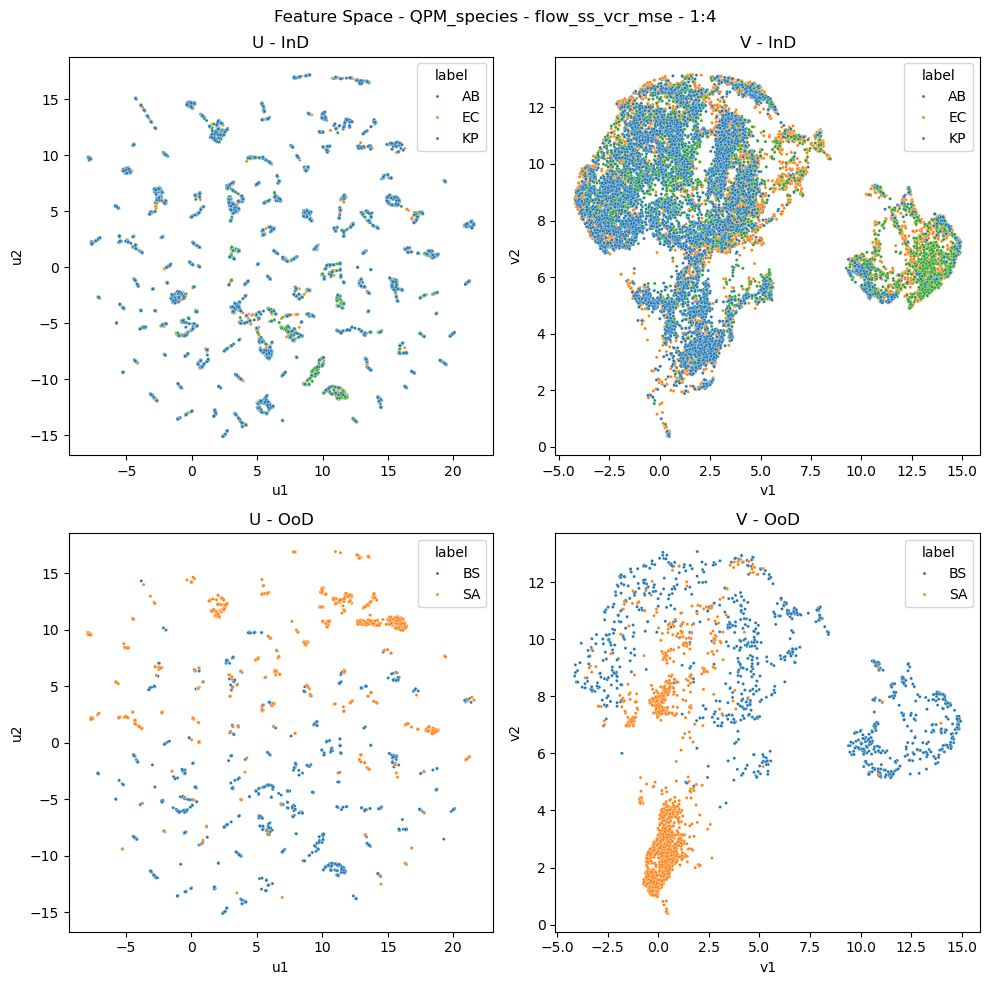

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

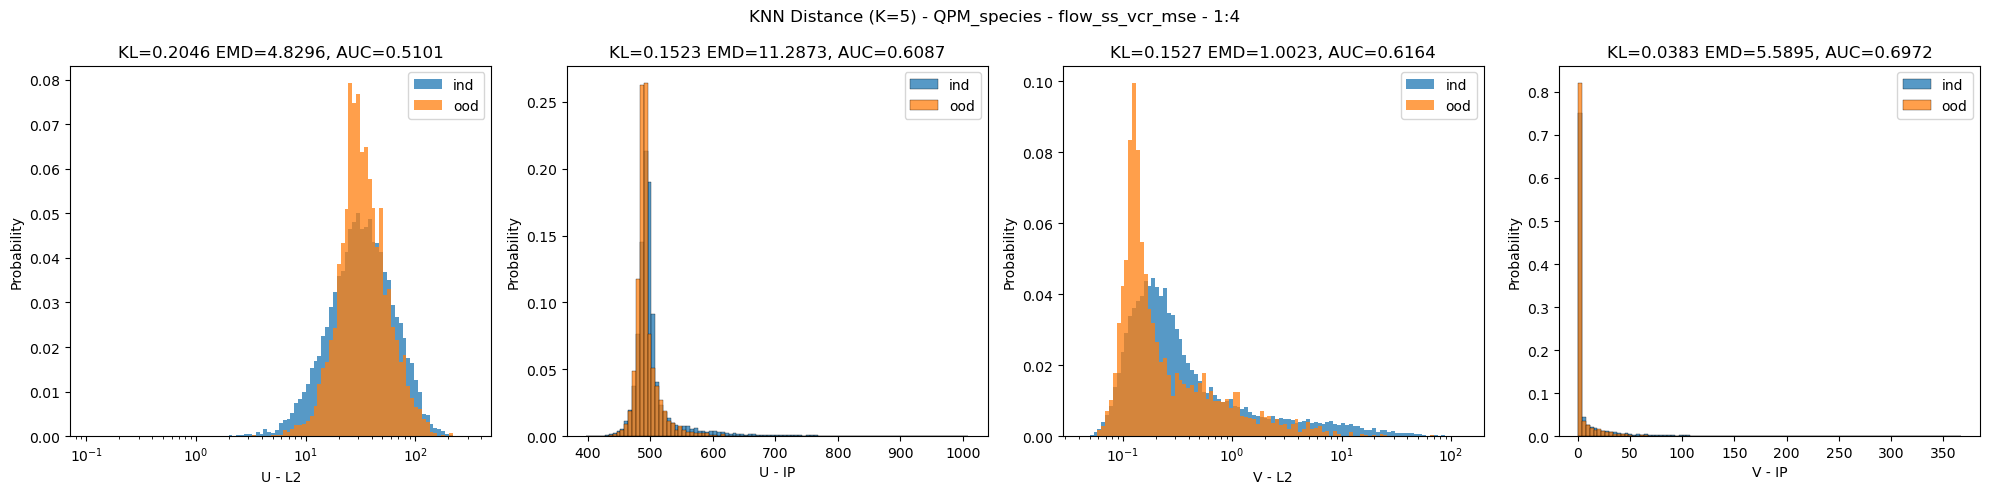

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

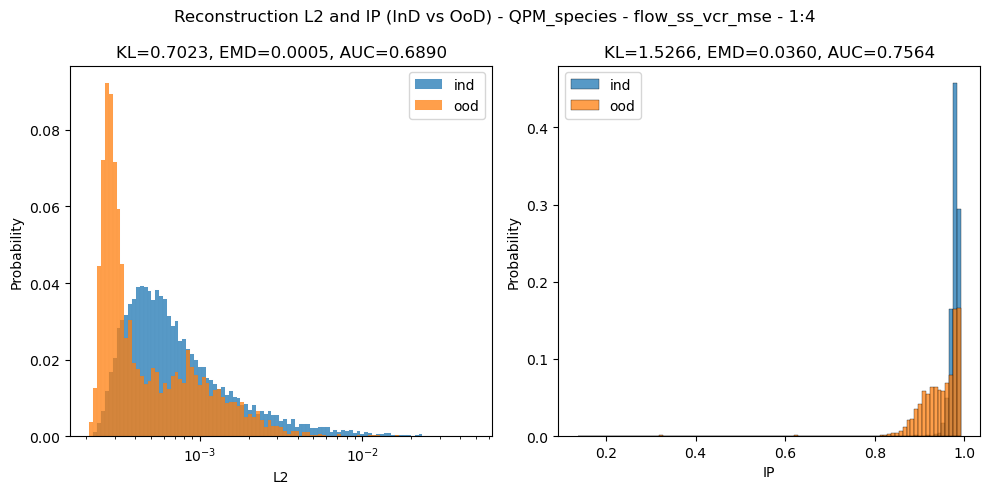

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.726313 0.6907675 1.4496739 1.6621497
22.684023 0.62525463 1.347364 1.5071396
22.807558 0.7789308 1.6510514 1.8963587
22.612398 0.39415362 1.1626675 1.1351779
33.403915 0.8896777 54.168358 0.73959595


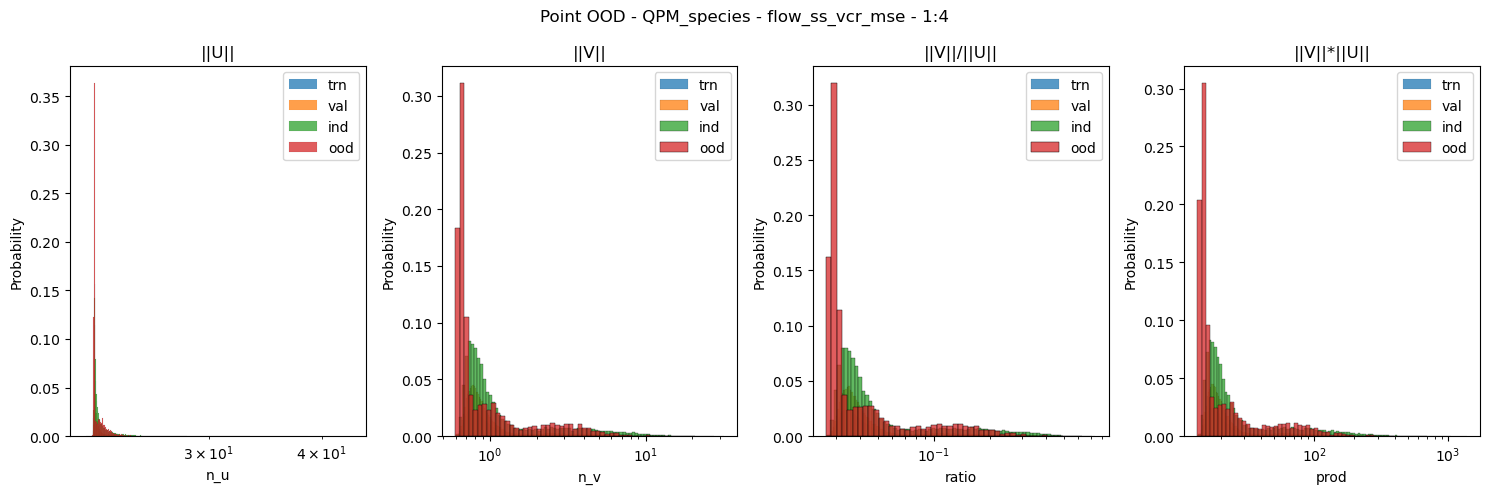

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


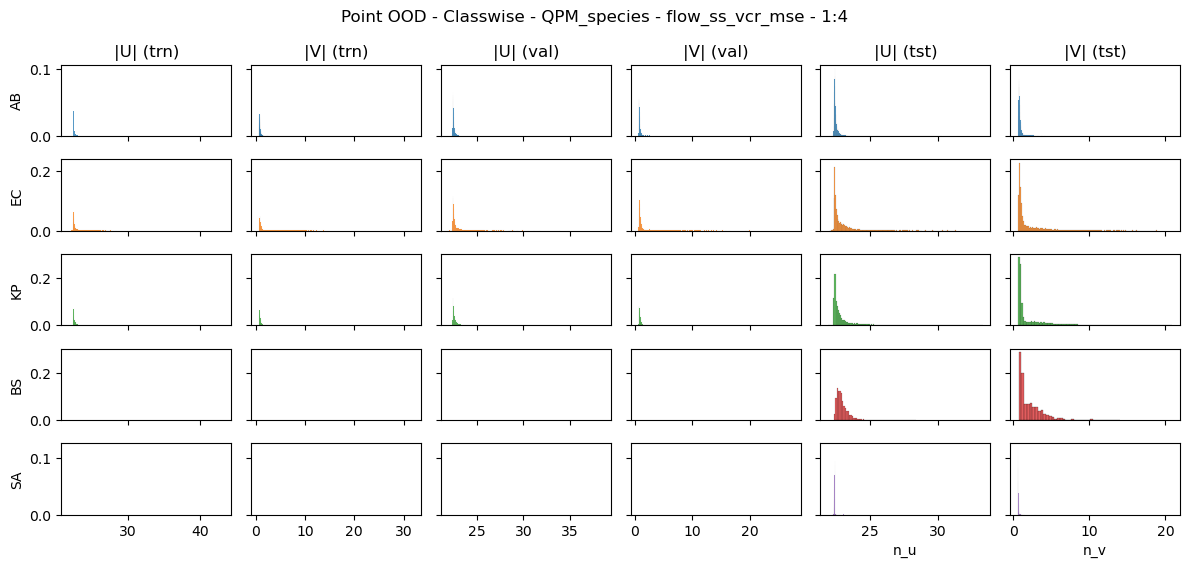

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

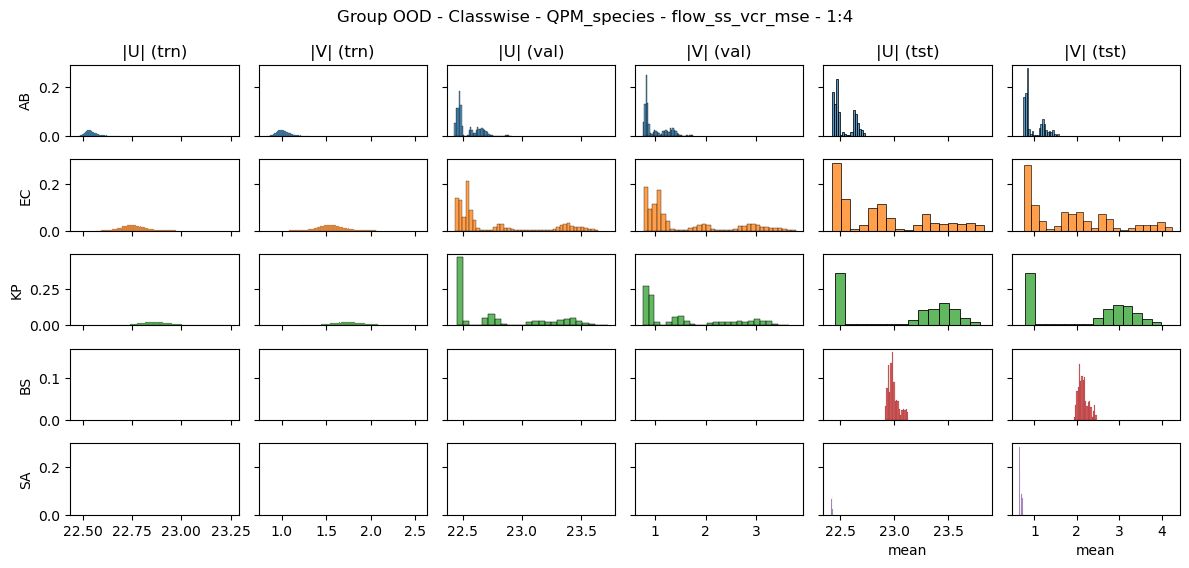

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)